The first part of this notebook is plotting histograms of the contingency tables with respect to the maximum-likelihood score for the multinomial model. Then, I attempted to do a test using both the maximum-likelihood score and the similarity index. The graphical representation of the test is a line supposed to separate to clouds of points corresponding to (maximum-likelihood estimator, similarity index) for each contingency table. This approach did seem to work mcuh better than using only the maximum likelihood estimator so it was abandoned.

In [1]:
### Import necessary libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tk
import scipy.stats as st

import matplotlib.colors as cl

In [2]:
### Fix directories

data_dir = "../data/initial database/output" #path to project folder

os.chdir(data_dir) #Select the project directory

In [3]:
### Import the data from the csv files

def select_directory(sample, file_name = "compounds", part = 1):
    """Returns the file directory corresponding to the file_name.csv file in the folder corresponding to the given sample
    (DiAcids, Fallopia, Ruthenium or Ruthenium2).
    
    the input part indicates the subfolder in which it is stored (pt1 or pt2)."""
    return data_dir + "/" + sample + "/pt" + str(part) + "/" + file_name + ".csv"

def df_from_csv(directory):
    """Extracts the csv file of the file contained in the directory and stores it in a pandas dataframe."""
    with open(directory) as file:
        return pd.read_csv(file)

#Convert the data into pandas dataframes and compute intratios.

sample_names = ["DiAcids", "Fallopia", "Ruthenium", "Ruthenium2"]

data = pd.DataFrame({"compounds" : [df_from_csv(select_directory(sample)) for sample in sample_names],
                     "peaks" : [df_from_csv(select_directory(sample, file_name = "ms2_peaks")) for sample in sample_names],
                     "spectra" : [df_from_csv(select_directory(sample, file_name = "ms2_spectra")) for sample in sample_names]
                    }, index = sample_names)

In [4]:
def peaks_in_list(sample):
    """Returns a dataframe indexed by spectrum_id with entries lists of mz, list of
    intensities and sum of intensities of the ms2 peaks corresponding to this spectrum id."""
    
    groups = data["peaks"][sample].groupby(["spectrum_id"])
    df = groups.agg(list)
    
    return df.loc[:,["mz", "intensity"]]

list_format_sp = pd.Series([peaks_in_list(sample) for sample in sample_names], index = sample_names)

In [5]:
def get_spectrum(sample, spectrum_id):
    """Select a spectrum in the list_format_sp dataframe."""
    return pd.Series(list_format_sp[sample].intensity[spectrum_id], index = list_format_sp[sample].mz[spectrum_id])

In [6]:
def ml_stat(table):
    """Given a contingency table, compute the statistic of the maximum likelihood
    for a test of independance between rows and columns, given by the formula
    T_ML = 2 * sum_{i, j} table_{i, j} log(table_[i, j] / m_{i, j})
    where m_{i, j} = (sum of row i) * (sum of column j) / (total sum of the table).
    
    The table should not contain non-positive values."""
    
    #Number of rows and columns of the table.
    r, c = table.shape
    
    #Compute the sums of the columns.
    col_sums = np.sum(table, axis = 0)

    #Compute the sums of the rows and stores them as a column vector.
    row_sums = np.expand_dims(np.sum(table, axis = 1), 1)
    
    #Total sum.
    total = np.sum(row_sums)
    
    #Compute the m_{i, j}.
    m = np.multiply(row_sums, col_sums) / total
    
    #Returns the result using the formula.
    return 2 * np.sum(table * np.log(table / m))

In [7]:
def display(spectrum):
    x = spectrum.index
    plt.bar(x, spectrum, width = .5)
    plt.yscale("log")

In [8]:
def make_table(sample, spectrum_id):
    """Make a contingency table out of the two spectra sp1 and sp2. Only consider peaks that are in both spectra.
    
    Input should be in the following form
    
    sample : a couple of sample names ("Fallopia", "DiAcids", "Ruthenium" or "Ruthenium2") ;
    spectrum_id : a couple of spectrum_id of the corresponding sample.
    
    The output is
    
    mz1 : mz values of the peaks selected in the first spectrum ;
    mz2 : idem for the second spectrum ;
    table : a 2 * d contingency tables containing the intensities of the selected peaks, where d is the number of selected peaks in each spectrum.    
    """
    
    #Extract the spectra as table with two columns, mz and intensity.
    sp1 = pd.DataFrame({"mz" : list_format_sp[sample[0]]["mz"][spectrum_id[0]],
                        "intensity" : list_format_sp[sample[0]]["intensity"][spectrum_id[0]]
                       })
    
    sp2 = pd.DataFrame({"mz" : list_format_sp[sample[1]]["mz"][spectrum_id[1]],
                        "intensity" : list_format_sp[sample[1]]["intensity"][spectrum_id[1]]
                       })
    
    #Initialization of mz1, mz2 and the rows of the output table.
    mz1, mz2 = [], []
    row1, row2 = [], []
    
    k1, k2 = len(sp1), len(sp2)
    
    #Indices running through the mz list.
    i, j = 0, 0
    while i < k1 and j < k2:
        
        if abs(sp1.mz[i] - sp2.mz[j]) < .001:
            #if the peaks have similar mz, their data is added to the output.
            mz1.append(sp1.mz[i])
            row1.append(sp1.intensity[i])
            mz2.append(sp2.mz[j])
            row2.append(sp2.intensity[j])
            i += 1
            j += 1
        
        #If the mz are distinct, the index corresponding to the smallest mz moves on to the next one (the mz are sorted in incresasing order in the sp_i.mz lists)
        elif sp1.mz[i] < sp2.mz[j]:
            i += 1
            
        else :
            j += 1
            
    return mz1, mz2, np.array([row1, row2])

In [9]:
#The code in this cell prepares dataframes and series for comparing spectra with same parent mz in Fallopia.

df = data["peaks"]["Fallopia"]
spectra = data["spectra"]["Fallopia"]
groups = spectra.groupby("compound_id")

#Sort the compound id by parent_mz.
sr = groups["parent_mz"].first().sort_values()
cid_by_parentmz = pd.DataFrame({"cid" : sr.index,
                    "pmz" : list(sr)
                   }, index = range(len(sr)))

#Selects compound_id when there is at least one other compound_id with the same parent mz.
pre_sel = list(abs(np.array(cid_by_parentmz.pmz)[1:] - np.array(cid_by_parentmz.pmz)[:-1]) < 0.001)
sel = np.array([False] + pre_sel) + np.array(pre_sel + [False])
cid_similar = cid_by_parentmz.loc[sel][:]
cid_similar.index = range(len(cid_similar.cid))

#Reduces precision of parent mz to to identify those who have the same.
cid_similar.pmz = pd.Series([int(100 * x) for x in cid_similar.pmz])

#Get gps a series containing lists of compound_id having the same parent mz.
gps = cid_similar.groupby("pmz").agg(list)
gps.index = range(len(gps))

#Maps compound_id to the list of spectrum_ids of that compound_id.
cid_spid = groups["spectrum_id"].agg(list)

In [10]:
#Functions to comptue maximum likelihood statistic (T_MN / T_LL) from the initial database 

def list_ml_stat(list_id1, list_id2):
    stat_list = []

    for spid1 in list_id1:
        for spid2 in list_id2:
            mz1, mz2, tb = make_table(["Fallopia", "Fallopia"], [spid1, spid2])
            if len(mz1) > 1:
                stat_list.append(ml_stat(tb))
    return pd.Series(stat_list)


from itertools import combinations

def list_ml_uni(list_id):
    stat_list = []
    
    for spid in combinations(list_id, 2):
        mz1, mz2, tb = make_table(["Fallopia", "Fallopia"], [spid[0], spid[1]])
        if len(mz1) > 1:
            stat_list.append(ml_stat(tb))
       
    return pd.Series(stat_list)
    

In [11]:
plt.rcParams["figure.figsize"] = (10, 6)

In [12]:
### Computes the same log-likelihood statistics as in the previous program, but also keeps in memory the number of columns in
### the initial table.

def list_ml_stat1(list_id1, list_id2):
    stat_list = []
    nb_list = []

    for spid1 in list_id1:
        for spid2 in list_id2:
            mz1, mz2, tb = make_table(["Fallopia", "Fallopia"], [spid1, spid2])
            stat_list.append(ml_stat(tb))
            nb_list.append(len(mz1))
    return pd.DataFrame({"stat" : stat_list, "nb_rows" : nb_list})


from itertools import combinations

def list_ml_uni1(list_id):
    stat_list = []
    nb_list = []
    
    for spid in combinations(list_id, 2):
        mz1, mz2, tb = make_table(["Fallopia", "Fallopia"], [spid[0], spid[1]])
        stat_list.append(ml_stat(tb))
        nb_list.append(len(mz1))
       
    return pd.DataFrame({"stat" : stat_list, "nb_rows" : nb_list})

In [ ]:
sub_directory = "../data/ll_files/"

In [13]:
ll_same = pd.read_csv(sub_directory + "ll_same.csv")
ll_diff = pd.read_csv(sub_directory + "ll_diff.csv")

In [14]:
def plot_ll_dist(df1, df2, nb_rows, nbins = 500):
    
    if nb_rows > 0:
        sr1 = df1.stat.loc[df1.nb_rows == nb_rows]
        sr2 = df2.stat.loc[df2.nb_rows == nb_rows]
    else:
        sr1 = df1.stat
        sr2 = df2.stat
    
    xmin = min(np.log(max(sr1.min(), 1e-3)) / np.log(10), np.log(max(sr2.min(), 1e-5)) / np.log(10))
    xmax = max(np.log(sr1.max()) / np.log(10), np.log(sr1.max()) / np.log(10))
    
    splits = np.linspace(xmin, xmax, nbins)
    lsr1 = np.log(sr1) / np.log(10)
    lsr2 = np.log(sr2) / np.log(10)
    
    lsr1.hist(bins = splits, color = "#C90000", alpha = .5, density = True, label = "same compound_id")
    lsr2.hist(bins = splits, color = "#3BF0F3", alpha = .5, density = True, label = "different compound_id")
    
    
    ticks = np.array((range(int(xmin) + 1, int(xmax) + 1)))
    plt.xticks(ticks)

    ax = plt.gca()
    ax.set_xticklabels(["1e" + str(exp) for exp in ticks])
    ax.xaxis.set_minor_locator(tk.NullLocator())

    plt.legend()

    plt.show()

The red and blue graphics are the first that I plotted. The green and red are the ones I used for my report and my slides.

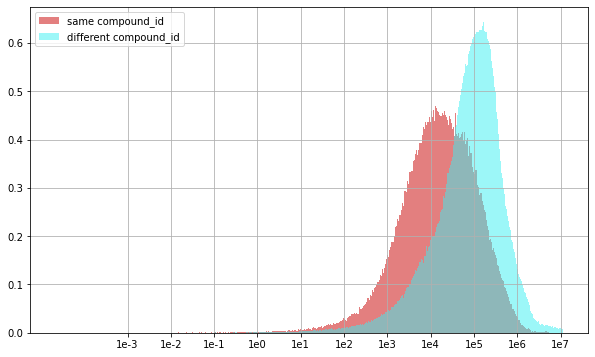

In [15]:
plot_ll_dist(ll_same.loc[ll_same["nb_rows"] > 1], ll_diff.loc[ll_diff["nb_rows"] > 1], 0)

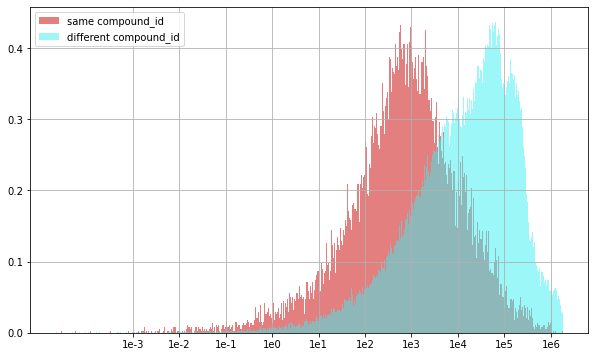

In [16]:
plot_ll_dist(ll_same, ll_diff, 2)

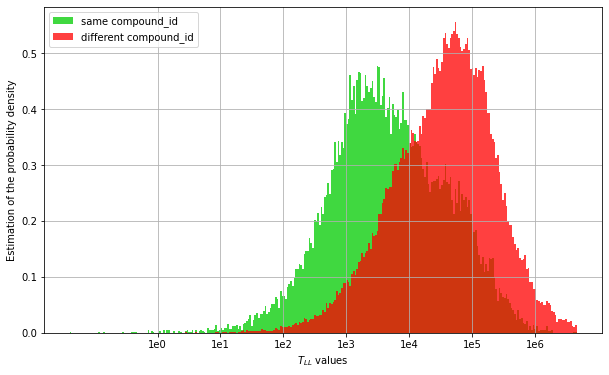

In [17]:
### plt.rcParams["figure.dpi"] = 200

nbins = 300
nb_rows = 3
df1 = ll_same
df2 = ll_diff

if nb_rows > 0:
    sr1 = df1.stat.loc[df1.nb_rows == nb_rows]
    sr2 = df2.stat.loc[df2.nb_rows == nb_rows]

    
xmin = min(np.log(max(sr1.min(), 1e-3)) / np.log(10), np.log(max(sr2.min(), 1e-5)) / np.log(10))
xmax = max(np.log(sr1.max()) / np.log(10), np.log(sr1.max()) / np.log(10))
    
splits = np.linspace(xmin, xmax, nbins)
lsr1 = np.log(sr1) / np.log(10)
lsr2 = np.log(sr2) / np.log(10)
    
lsr1.hist(bins = splits, color = (0, 0.8, 0), alpha = .75, density = True, label = "same compound_id")
lsr2.hist(bins = splits, color = (1, 0, 0), alpha = .75, density = True, label = "different compound_id")
    
    
ticks = np.array((range(int(xmin) + 1, int(xmax) + 1)))
plt.xticks(ticks)

ax = plt.gca()
ax.set_xticklabels(["1e" + str(exp) for exp in ticks])
ax.xaxis.set_minor_locator(tk.NullLocator())

plt.xlabel("$T_{LL}$ values")
plt.ylabel("Estimation of the probability density")

plt.legend()


plt.show()

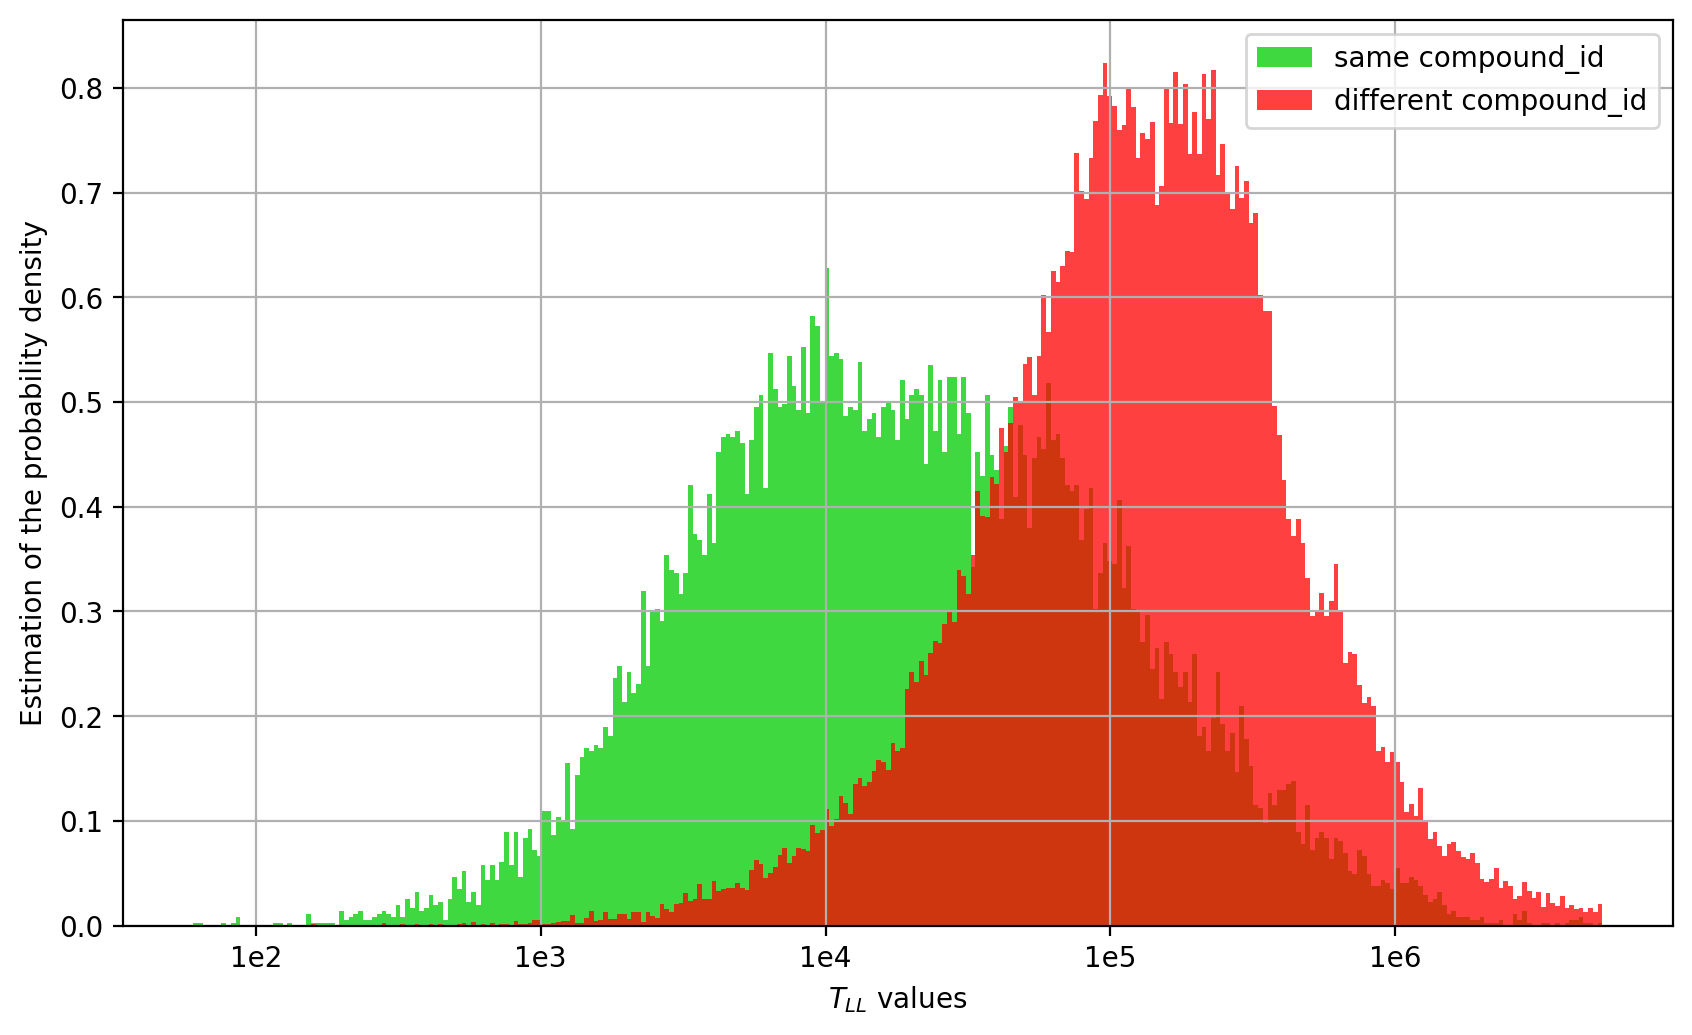

In [18]:
plt.rcParams["figure.dpi"] = 200

nbins = 300
nb_rows = 7
df1 = ll_same
df2 = ll_diff

if nb_rows > 0:
    sr1 = df1.stat.loc[df1.nb_rows == nb_rows]
    sr2 = df2.stat.loc[df2.nb_rows == nb_rows]

    
xmin = min(np.log(max(sr1.min(), 1e-3)) / np.log(10), np.log(max(sr2.min(), 1e-5)) / np.log(10))
xmax = max(np.log(sr1.max()) / np.log(10), np.log(sr1.max()) / np.log(10))
    
splits = np.linspace(xmin, xmax, nbins)
lsr1 = np.log(sr1) / np.log(10)
lsr2 = np.log(sr2) / np.log(10)
    
lsr1.hist(bins = splits, color = (0, 0.8, 0), alpha = .75, density = True, label = "same compound_id")
lsr2.hist(bins = splits, color = (1, 0, 0), alpha = .75, density = True, label = "different compound_id")
    
    
ticks = np.array((range(int(xmin) + 1, int(xmax) + 1)))
plt.xticks(ticks)

ax = plt.gca()
ax.set_xticklabels(["1e" + str(exp) for exp in ticks])
ax.xaxis.set_minor_locator(tk.NullLocator())

plt.xlabel("$T_{LL}$ values")
plt.ylabel("Estimation of the probability density")

plt.legend()


plt.show()

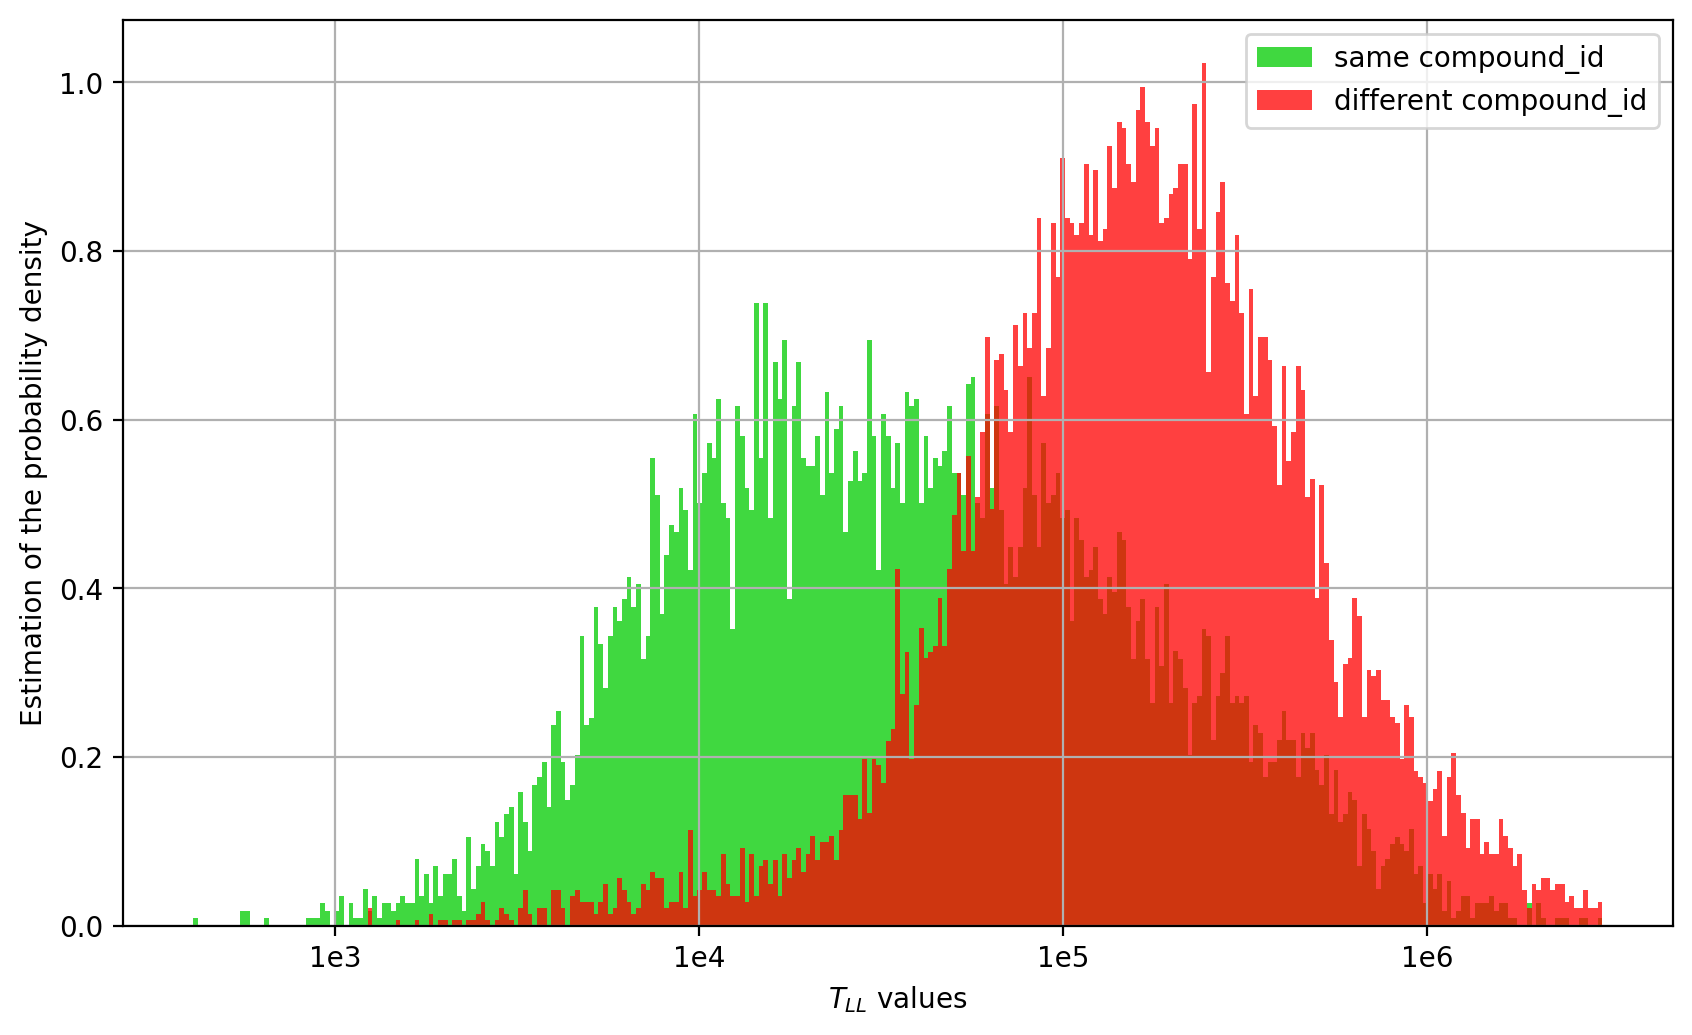

In [19]:
plt.rcParams["figure.dpi"] = 200

nbins = 300
nb_rows = 12
df1 = ll_same
df2 = ll_diff

if nb_rows > 0:
    sr1 = df1.stat.loc[df1.nb_rows == nb_rows]
    sr2 = df2.stat.loc[df2.nb_rows == nb_rows]

    
xmin = min(np.log(max(sr1.min(), 1e-3)) / np.log(10), np.log(max(sr2.min(), 1e-5)) / np.log(10))
xmax = max(np.log(sr1.max()) / np.log(10), np.log(sr1.max()) / np.log(10))
    
splits = np.linspace(xmin, xmax, nbins)
lsr1 = np.log(sr1) / np.log(10)
lsr2 = np.log(sr2) / np.log(10)
    
lsr1.hist(bins = splits, color = (0, 0.8, 0), alpha = .75, density = True, label = "same compound_id")
lsr2.hist(bins = splits, color = (1, 0, 0), alpha = .75, density = True, label = "different compound_id")
    
    
ticks = np.array((range(int(xmin) + 1, int(xmax) + 1)))
plt.xticks(ticks)

ax = plt.gca()
ax.set_xticklabels(["1e" + str(exp) for exp in ticks])
ax.xaxis.set_minor_locator(tk.NullLocator())

plt.xlabel("$T_{LL}$ values")
plt.ylabel("Estimation of the probability density")

plt.legend()


plt.show()

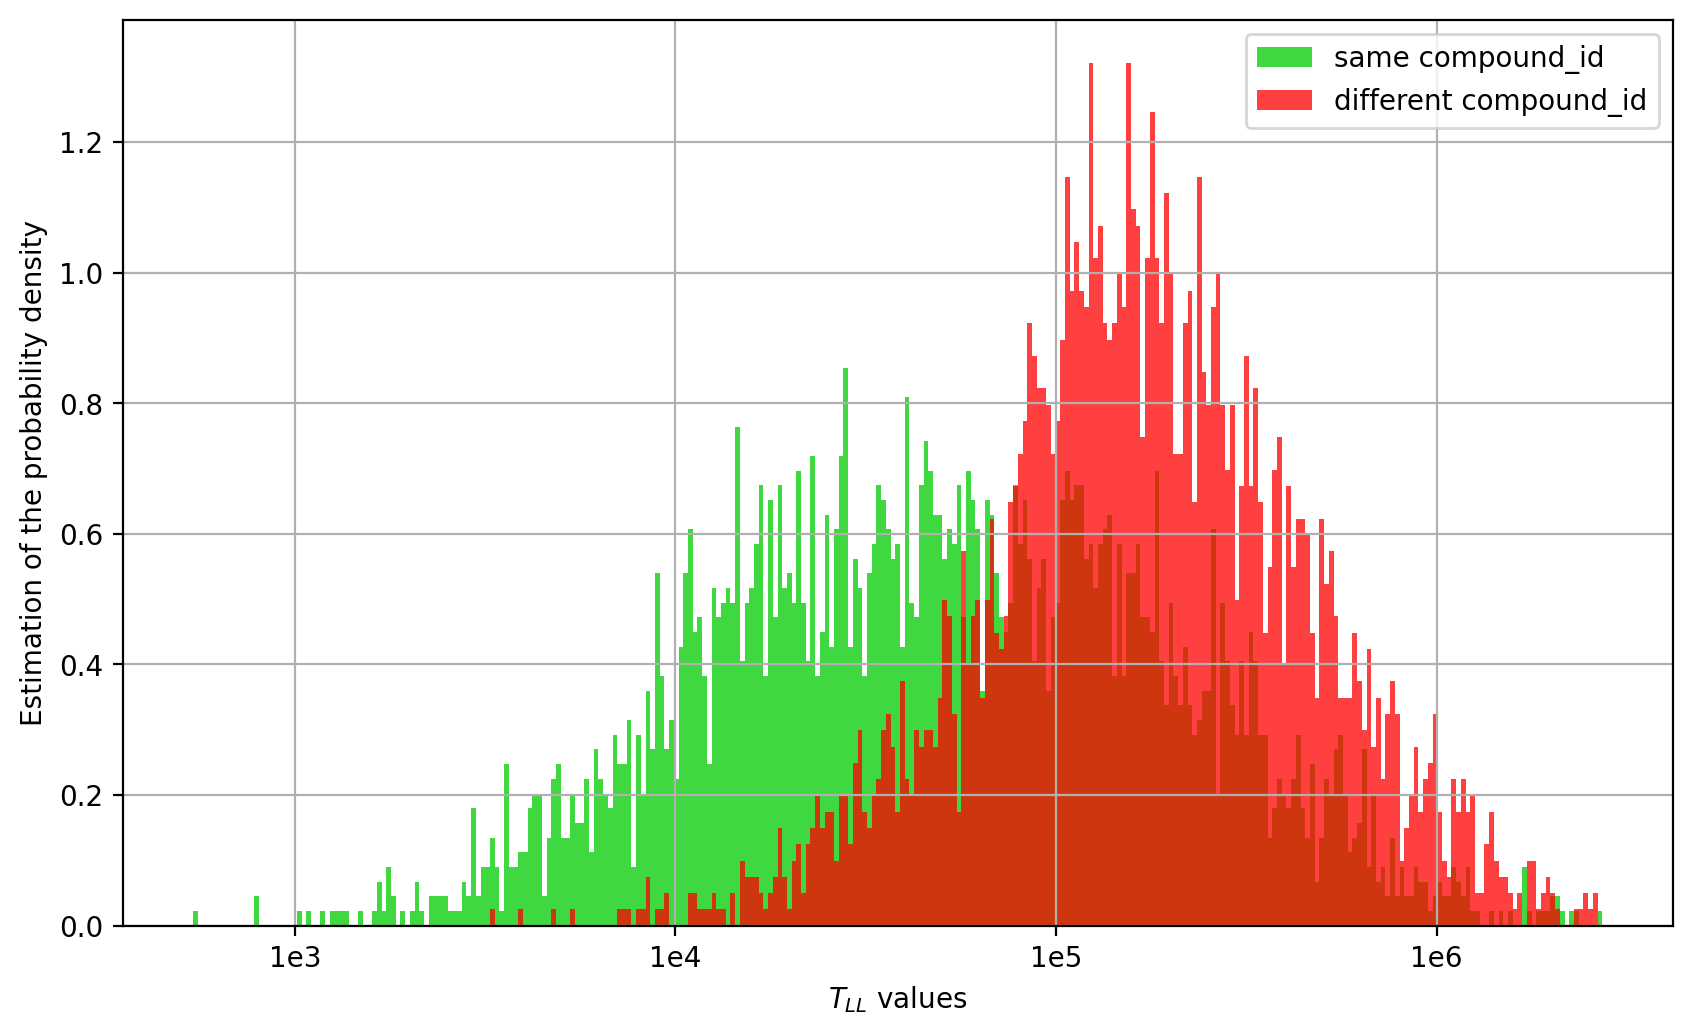

In [20]:
plt.rcParams["figure.dpi"] = 200

nbins = 300
nb_rows = 16
df1 = ll_same
df2 = ll_diff

if nb_rows > 0:
    sr1 = df1.stat.loc[df1.nb_rows == nb_rows]
    sr2 = df2.stat.loc[df2.nb_rows == nb_rows]

    
xmin = min(np.log(max(sr1.min(), 1e-3)) / np.log(10), np.log(max(sr2.min(), 1e-5)) / np.log(10))
xmax = max(np.log(sr1.max()) / np.log(10), np.log(sr1.max()) / np.log(10))
    
splits = np.linspace(xmin, xmax, nbins)
lsr1 = np.log(sr1) / np.log(10)
lsr2 = np.log(sr2) / np.log(10)
    
lsr1.hist(bins = splits, color = (0, 0.8, 0), alpha = .75, density = True, label = "same compound_id")
lsr2.hist(bins = splits, color = (1, 0, 0), alpha = .75, density = True, label = "different compound_id")
    
    
ticks = np.array((range(int(xmin) + 1, int(xmax) + 1)))
plt.xticks(ticks)

ax = plt.gca()
ax.set_xticklabels(["1e" + str(exp) for exp in ticks])
ax.xaxis.set_minor_locator(tk.NullLocator())

plt.xlabel("$T_{LL}$ values")
plt.ylabel("Estimation of the probability density")

plt.legend()


plt.show()

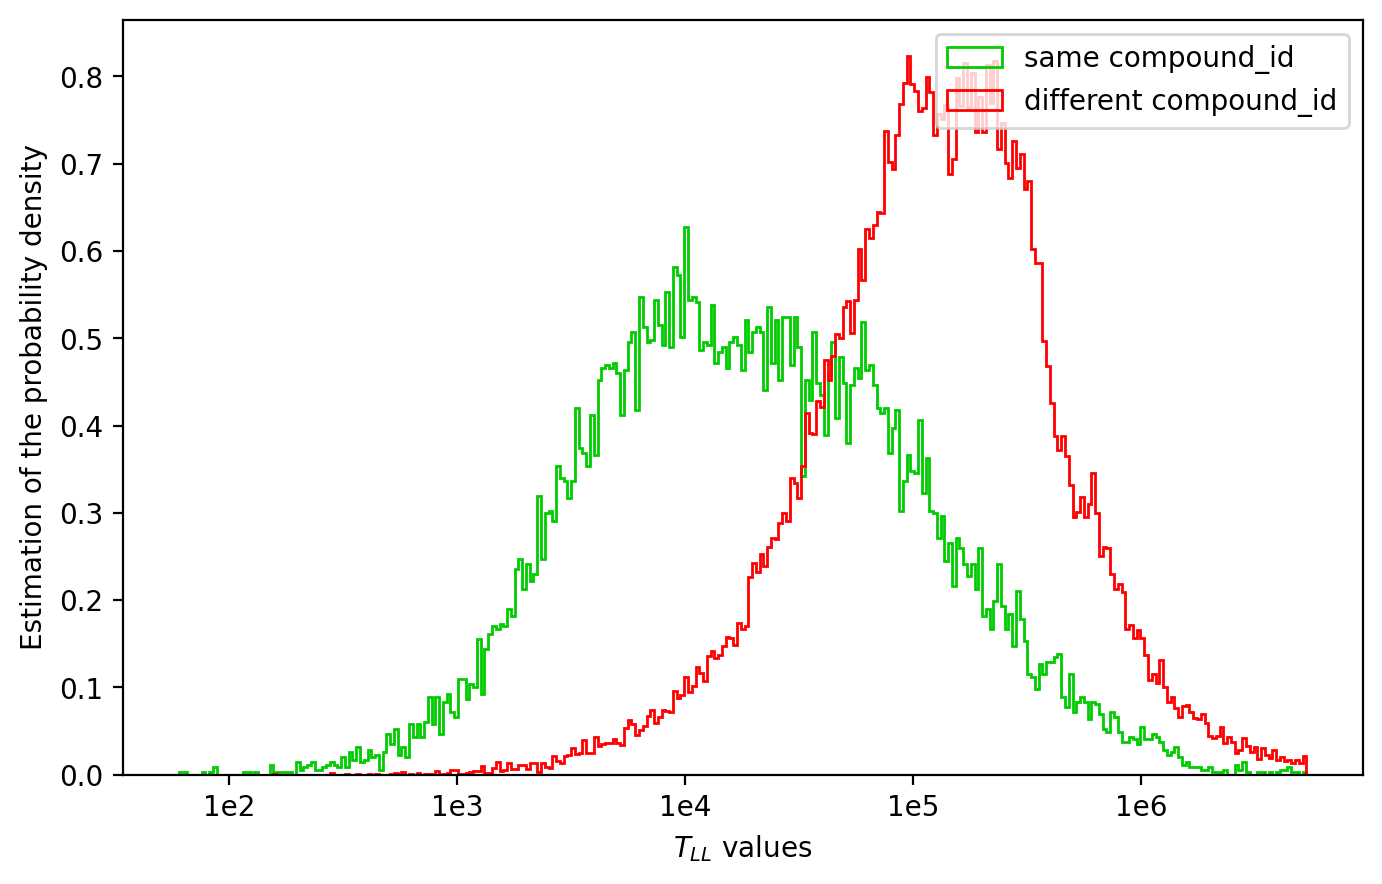

In [21]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["figure.dpi"] = 200

nbins = 300
nb_rows = 7
df1 = ll_same
df2 = ll_diff

if nb_rows > 0:
    sr1 = df1.stat.loc[df1.nb_rows == nb_rows]
    sr2 = df2.stat.loc[df2.nb_rows == nb_rows]

    
xmin = min(np.log(max(sr1.min(), 1e-3)) / np.log(10), np.log(max(sr2.min(), 1e-5)) / np.log(10))
xmax = max(np.log(sr1.max()) / np.log(10), np.log(sr1.max()) / np.log(10))
    
splits = np.linspace(xmin, xmax, nbins)
lsr1 = np.log(sr1) / np.log(10)
lsr2 = np.log(sr2) / np.log(10)
    
hist1 = plt.hist(lsr1, bins = splits, color = (0, .8, 0), density = True, label = "same compound_id", histtype ="step")
hist2 = plt.hist(lsr2, bins = splits, color = (1, 0, 0), density = True, label = "different compound_id", histtype = "step")
    
    
ticks = np.array((range(int(xmin) + 1, int(xmax) + 1)))
plt.xticks(ticks)

ax = plt.gca()
ax.set_xticklabels(["1e" + str(exp) for exp in ticks])
ax.xaxis.set_minor_locator(tk.NullLocator())

plt.xlabel("$T_{LL}$ values")
plt.ylabel("Estimation of the probability density")

plt.legend()

plt.show()

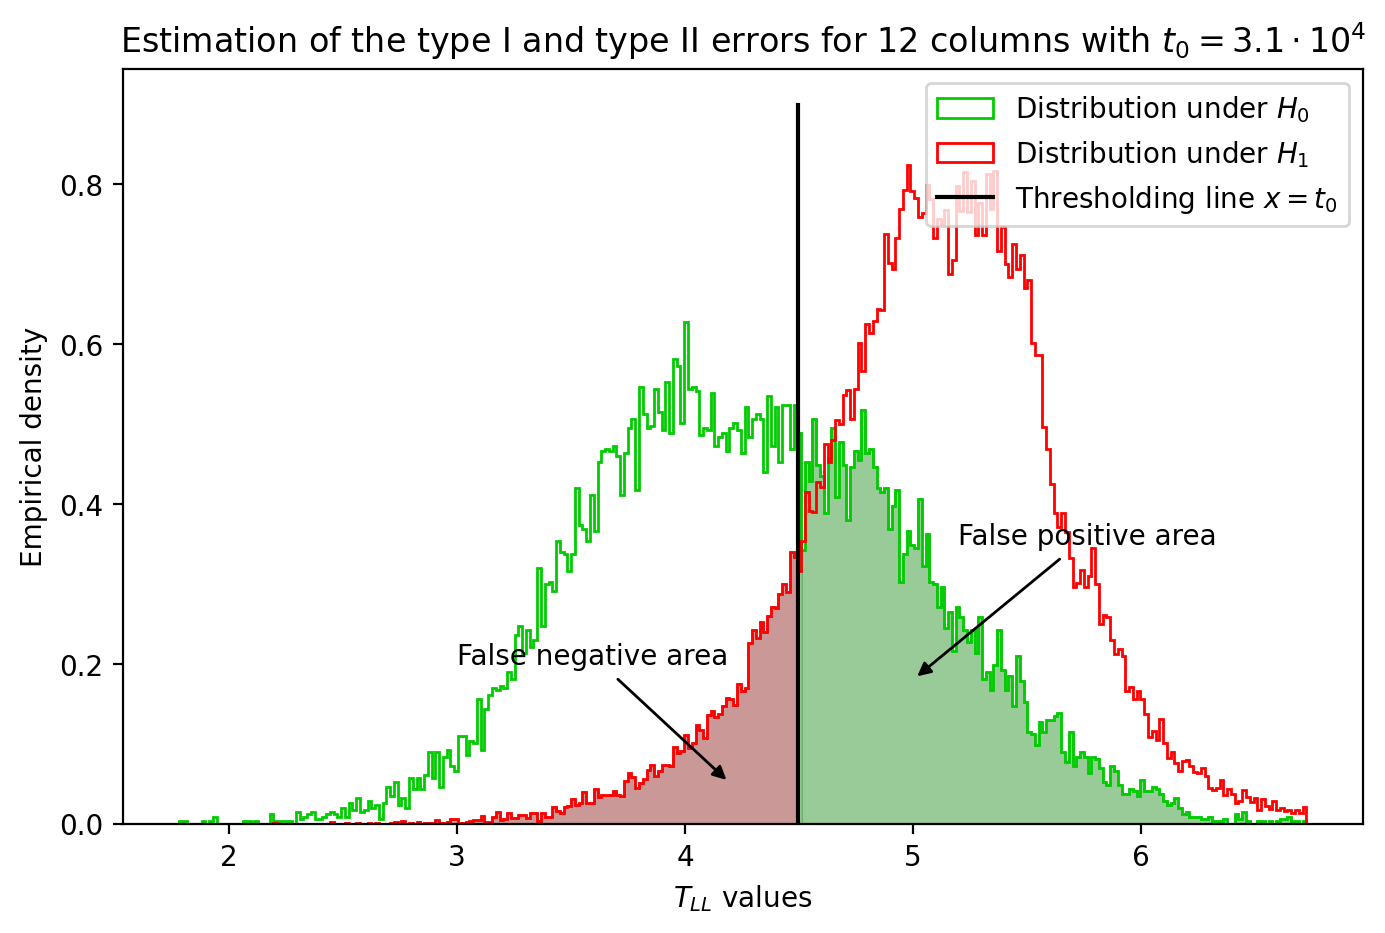

In [22]:
threshold = np.log(31306.263785584357) / np.log(10)


hist1 = plt.hist(lsr1,
                 bins = splits,
                 color = (0, 0.8, 0),
                 density = True,
                 label = "Distribution under $H_0$",
                 histtype ="step"
                )

values1 = hist1[0]
ind1 = hist1[1][1:]
plt.fill_between(ind1[ind1 > threshold], values1[ind1 > threshold],
                 color = (0.2, 0.6, 0.2),
                 alpha = .5,
                 step = "pre"
                )

plt.annotate("False positive area",
             xy = [5, 0.18],
             xytext = [5.2, 0.35],
             arrowprops = dict(arrowstyle = '-|>', color='k')
            )

hist2 = plt.hist(lsr2,
                 bins = splits,
                 color = "red",
                 density = True,
                 label = "Distribution under $H_1$",
                 histtype = "step"
                )

values2 = hist2[0]
ind2 = hist2[1][1:]
plt.fill_between(ind2[ind2 <= threshold],
                 values2[ind2 <= threshold],
                 color = (0.6, 0.2, 0.2),
                 alpha = .5,
                 step = "pre"
                )

plt.annotate("False negative area",
             xy = [4.2, 0.05],
             xytext = [3, 0.2],
             arrowprops = dict(arrowstyle = '-|>', color='k')
            )

plt.plot([threshold, threshold], [0, 0.9], color = "black", label = "Thresholding line $x = t_0$")

plt.xlabel("$T_{LL}$ values")
plt.ylabel("Empirical density")
plt.legend()
plt.title("Estimation of the type I and type II errors for 12 columns with $t_0 = 3.1 \cdot 10^4$")

plt.show()

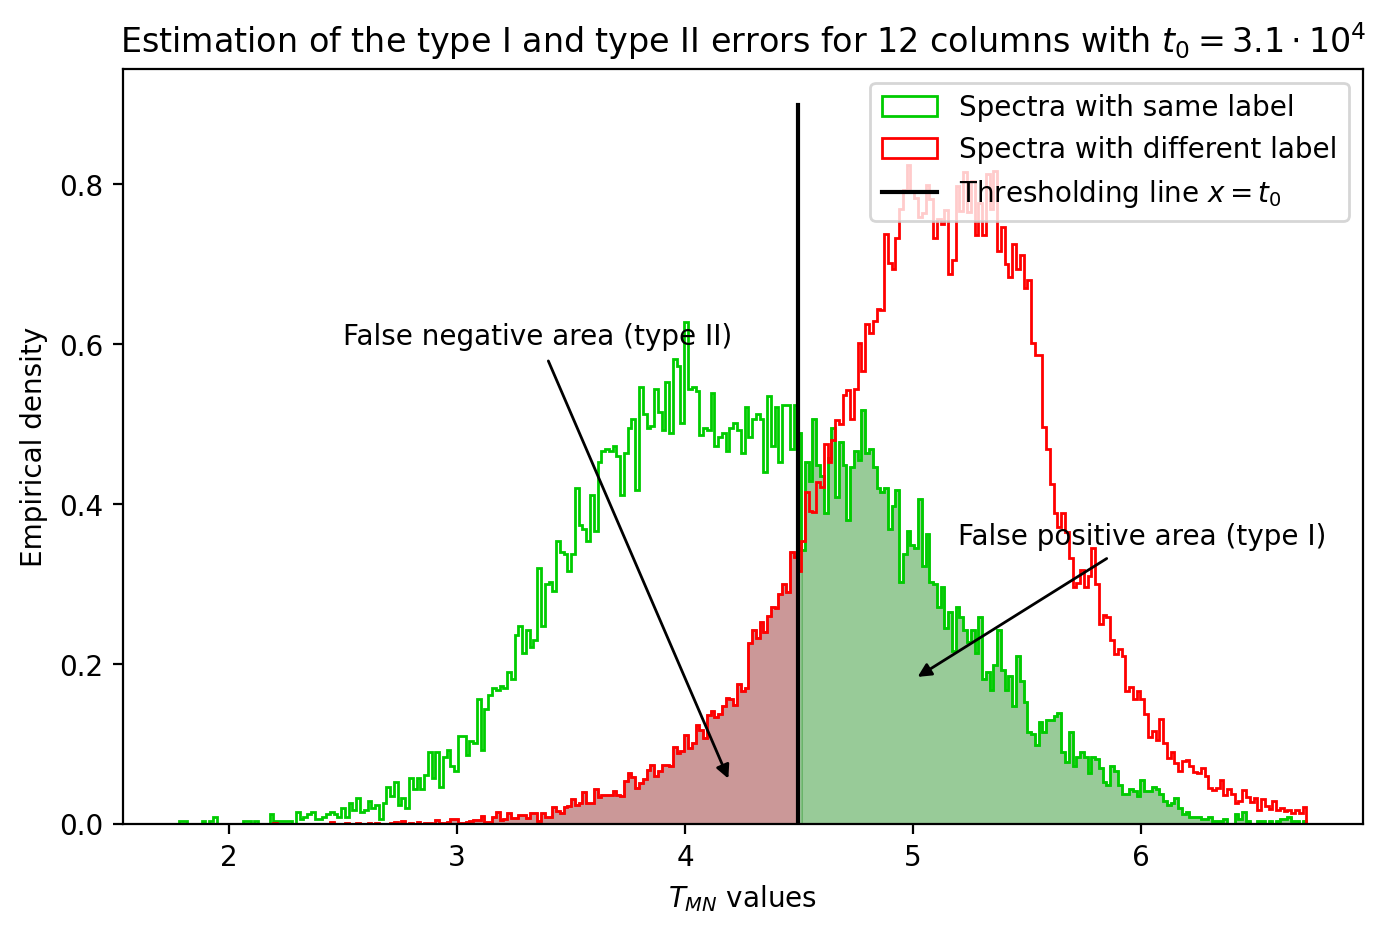

In [26]:
threshold = np.log(31306.263785584357) / np.log(10)


hist1 = plt.hist(lsr1,
                 bins = splits,
                 color = (0, 0.8, 0),
                 density = True,
                 label = "Spectra with same label",
                 histtype ="step"
                )

values1 = hist1[0]
ind1 = hist1[1][1:]
plt.fill_between(ind1[ind1 > threshold], values1[ind1 > threshold],
                 color = (0.2, 0.6, 0.2),
                 alpha = .5,
                 step = "pre"
                )

plt.annotate("False positive area (type I)",
             xy = [5, 0.18],
             xytext = [5.2, 0.35],
             arrowprops = dict(arrowstyle = '-|>', color='k')
            )

hist2 = plt.hist(lsr2,
                 bins = splits,
                 color = "red",
                 density = True,
                 label = "Spectra with different label",
                 histtype = "step"
                )

values2 = hist2[0]
ind2 = hist2[1][1:]
plt.fill_between(ind2[ind2 <= threshold],
                 values2[ind2 <= threshold],
                 color = (0.6, 0.2, 0.2),
                 alpha = .5,
                 step = "pre"
                )

plt.annotate("False negative area (type II)",
             xy = [4.2, 0.05],
             xytext = [2.5, 0.6],
             arrowprops = dict(arrowstyle = '-|>', color='k')
            )

plt.plot([threshold, threshold], [0, 0.9], color = "black", label = "Thresholding line $x = t_0$")

plt.xlabel("$T_{MN}$ values")
plt.ylabel("Empirical density")
plt.legend()
plt.title("Estimation of the type I and type II errors for 12 columns with $t_0 = 3.1 \cdot 10^4$")

plt.show()

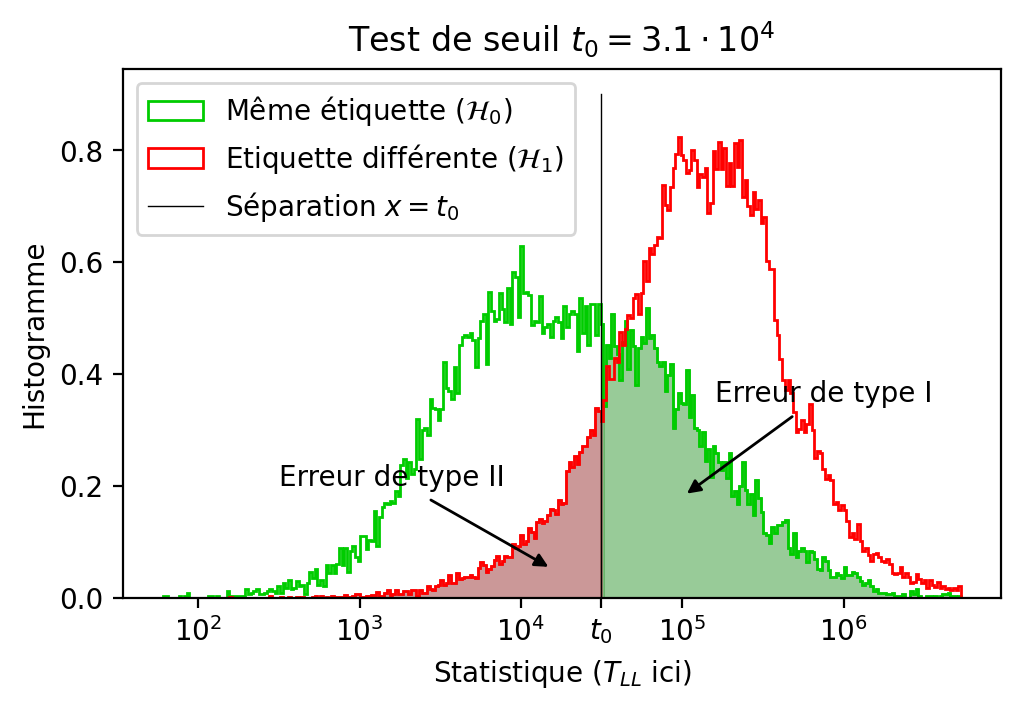

In [37]:
plt.rcParams["figure.figsize"] = (34 / 6, 21 / 6)

hist1 = plt.hist(lsr1,
                 bins = splits,
                 color = (0, 0.8, 0),
                 density = True,
                 label = "Même étiquette ($\mathcal{H}_0)$",
                 histtype ="step"
                )

values1 = hist1[0]
ind1 = hist1[1][1:]
plt.fill_between(ind1[ind1 > threshold], values1[ind1 > threshold],
                 color = (0.2, 0.6, 0.2),
                 alpha = .5,
                 step = "pre"
                )

plt.annotate("Erreur de type I",
             xy = [5, 0.18],
             xytext = [5.2, 0.35],
             arrowprops = dict(arrowstyle = '-|>', color='k')
            )

hist2 = plt.hist(lsr2,
                 bins = splits,
                 color = "red",
                 density = True,
                 label = "Etiquette différente ($\mathcal{H}_1$)",
                 histtype = "step"
                )

values2 = hist2[0]
ind2 = hist2[1][1:]
plt.fill_between(ind2[ind2 <= threshold],
                 values2[ind2 <= threshold],
                 color = (0.6, 0.2, 0.2),
                 alpha = .5,
                 step = "pre"
                )

plt.annotate("Erreur de type II",
             xy = [4.2, 0.05],
             xytext = [2.5, 0.2],
             arrowprops = dict(arrowstyle = '-|>', color='k')
            )

plt.plot([threshold, threshold], [0, 0.9], color = "black", linewidth = .5, label = "Séparation $x = t_0$")

plt.xticks([2, 3, threshold, 4, 5, 6])
ax = plt.gca()
ax.set_xticklabels([r"$10^2$", r"$10^3$", r"$t_0$", r"$10^4$", r"$10^5$", r"$10^6$"])
ax.xaxis.set_minor_locator(tk.NullLocator())

plt.xlabel(r"Statistique ($T_{LL}$ ici)")
plt.ylabel("Histogramme")
plt.legend()
plt.title(r"Test de seuil $t_0 = 3.1 \cdot 10^{4}$")

plt.show()

In [23]:
alp0 = 0.3877551
th0 = sr1.quantile(1 - alp0)
beta0 = sum(sr2 > th0) / len(sr2)

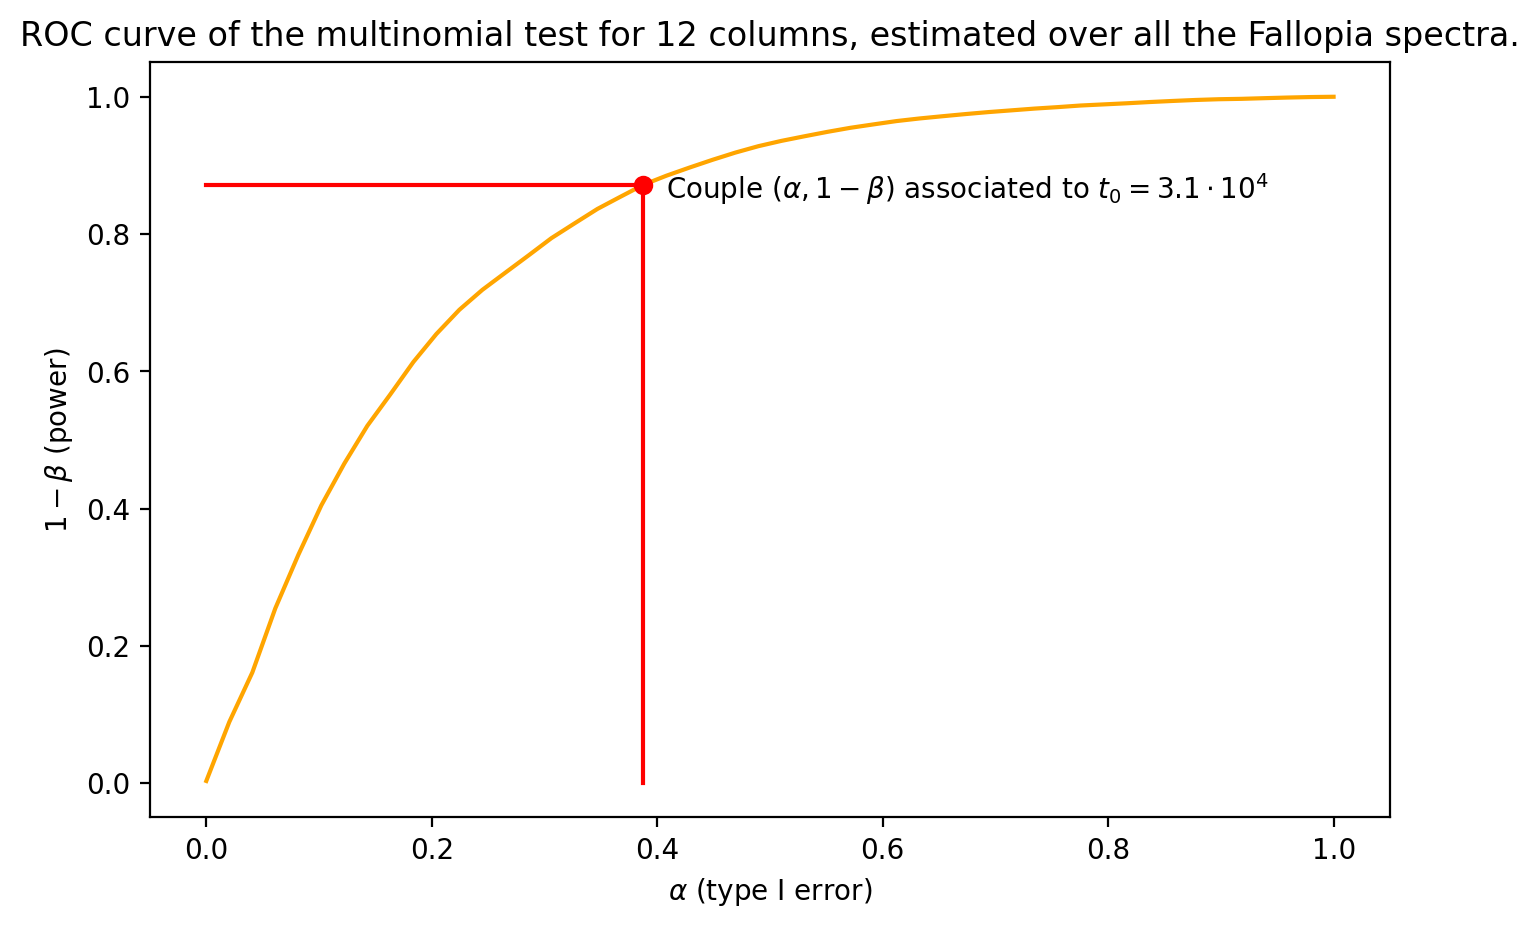

In [29]:
alphas = np.linspace(0, 1)
betas = []

for alpha in alphas:
    th  = sr1.quantile(1 - alpha)
    betas.append(sum(sr2 > th) / len(sr2))
    
plt.plot(alphas, betas, "orange")

plt.plot([alp0, alp0], [0, beta0], "red")
plt.plot([0, alp0], [beta0, beta0], "red")
plt.plot([alp0], [beta0], color = "red", marker = "o")

plt.annotate(r"Couple $(\alpha, 1 - \beta)$ associated to $t_0 = 3.1 \cdot 10^4$", xy = [alp0, beta0], xytext = [alp0 + 0.02, beta0 - 0.02])


plt.xlabel(r"$\alpha$ (type I error)")
plt.ylabel(r"$1 - \beta$ (power)")

plt.title("ROC curve of the multinomial test for 12 columns, estimated over all the Fallopia spectra.")


plt.show()
    

In [62]:
alphas

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

In [70]:
sr1.quantile(1 - 0.3877551)

31306.263785584357

In [72]:
sum(sr2 > 31306.263785584357) / len(sr2)

0.8717720229868335

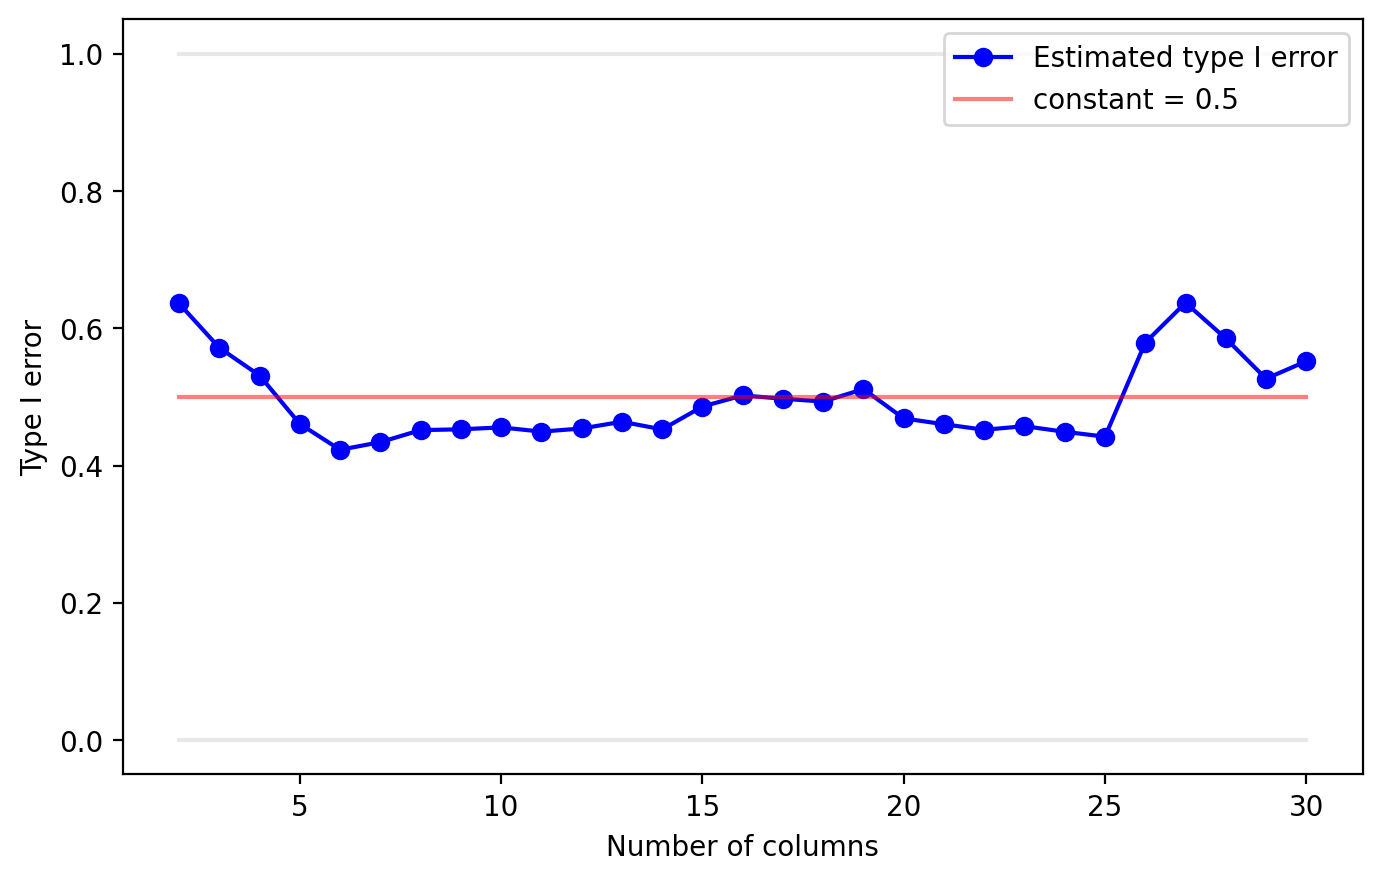

In [24]:
nb_cols = np.arange(2, 31)
beta = 0.1
alphas = []

for nb_rows in nb_cols:
    
    sr1 = df1.stat.loc[df1.nb_rows == nb_rows]
    sr2 = df2.stat.loc[df2.nb_rows == nb_rows]
     
    th = sr2.quantile(beta)
    alpha = sum(sr1 > th) / len(sr1)
    alphas.append(alpha)
    
plt.plot(nb_cols, alphas, marker = "o", color = "blue", label = "Estimated type I error")
plt.plot(nb_cols, len(nb_cols) * [0], color = "lightgrey", alpha = 0.5)
plt.plot(nb_cols, len(nb_cols) * [1], color = "lightgrey", alpha = 0.5)
plt.plot(nb_cols, len(nb_cols) * [0.5], color = "red", alpha = 0.5, label = "constant = 0.5")

plt.xlabel("Number of columns")
plt.ylabel("Type I error")

plt.legend()

plt.show()

In [31]:
nb_col

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

The log-likelihood statistic seems to perform better without the threshold of $10^4$ that is used to select less more peaks assuming that they aren't noise. It seems to draw the distribution for same compounds towards the right more than it does for distinct compounds.

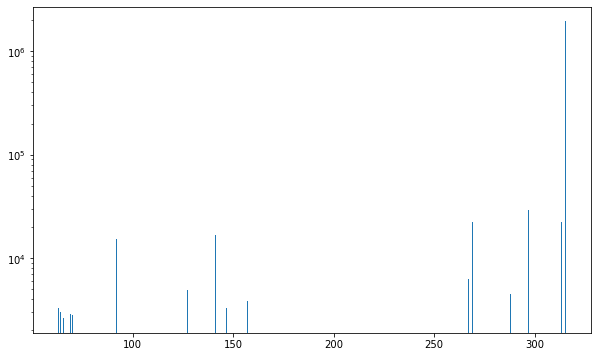

In [18]:
display(get_spectrum("Fallopia", "R04_01_1814"))

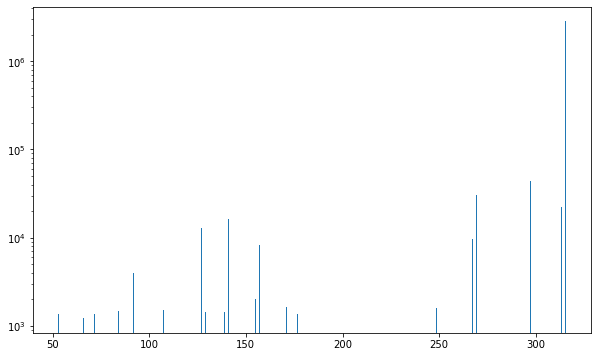

In [19]:
display(get_spectrum("Fallopia", "R04_03_1734"))

In [20]:
len(get_spectrum("Fallopia", "R04_01_1814"))

16

In [21]:
lst_couple_cid = []

for lst_cid in gps.cid:
    lst_couple_cid += combinations(lst_cid, 2)

In [22]:
#Changed a few lines in Eliza's program

# Functions to compare spectra using Gaussian dot product of all peaks
# s1 = a series of mz values
# idem for s2
# Returns similarity between s1 and s2
def gp_mz_ppm(s1, s2, var_mz_ppm = 10 / 1.96):
    
    s1_mz, s2_mz = np.meshgrid(s1 ,s2) # Tile to compare all peaks
    comp_mz_ppm = ((s1_mz - s2_mz) / ((s1_mz + s2_mz) / 2) * 1e6) ** 2
    gauss_prod_mz = (comp_mz_ppm / var_mz_ppm)
    gp = np.exp(- (1 / 8) * gauss_prod_mz)
    return np.nansum(gp[gp > .535])

    # Note: This threshold delivers peaks within 5 standard deviations, eg. np.exp(-1/8*5)=0.535

In [23]:
def get_spectrum_mz(sample, spectrum_id):
    """Select a spectrum in the list_format_sp dataframe."""
    return pd.Series(list_format_sp[sample].mz[spectrum_id])

def sim_index_norm(sample, spectrum_id):
    s1 = get_spectrum_mz(sample[0], spectrum_id[0])
    s2 = get_spectrum_mz(sample[1], spectrum_id[1])
    return gp_mz_ppm(s1, s2) / np.sqrt(gp_mz_ppm(s1, s1) * gp_mz_ppm(s2, s2))

In [24]:
def list_sim_index(list_id1, list_id2):
    stat_list = []
    nb_list = []

    for spid1 in list_id1:
        for spid2 in list_id2:
            stat_list.append(sim_index_norm(["Fallopia", "Fallopia"], [spid1, spid2]))
    return pd.Series(stat_list, dtype = "object")


from itertools import combinations

def list_sim_index_uni(list_id):
    stat_list = []
    nb_list = []
    
    for spid in combinations(list_id, 2):
        stat_list.append(sim_index_norm(["Fallopia", "Fallopia"], [spid[0], spid[1]]))
       
    return pd.Series(stat_list, dtype = "object")

In [25]:
sim_index_norm(["Fallopia", "Fallopia"], ["R04_01_1814", "R04_01_1814"])

1.0

In [26]:
sim_index_norm(["Fallopia", "Fallopia"], ["R04_01_1814", "R04_03_1734"])

0.38610276967266277

In [27]:
sim_same = pd.read_csv(sub_directory + "sim_same.csv")["0"]
sim_diff = pd.read_csv(sub_directory + "sim_diff.csv")["0"]

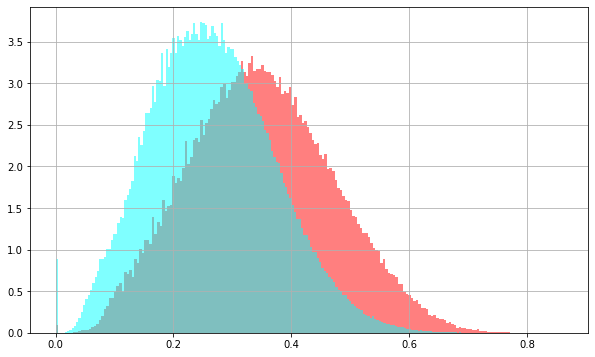

In [28]:
sim_same.hist(bins = 200, density = True, color = "red", alpha = .5)
sim_diff.hist(bins = 200, density = True, color = "cyan", alpha = .5)
plt.show()

In [127]:
def color_density(ll, sim, bins = 200):
    a1 = np.log(ll.stat) / np.log(10)
    
    #plt.figure(figsize = (10, 10))
    plt.hist2d(a1, sim, bins = bins, norm = cl.LogNorm())
    plt.show()
    
def color_density_wfeatures(ll, sim, ran, bins = 200):
    a1 = np.log(ll.stat) / np.log(10)
    
    #plt.figure(figsize = (10, 10))
    plt.hist2d(a1, sim, range = ran, bins = bins, norm = cl.LogNorm())

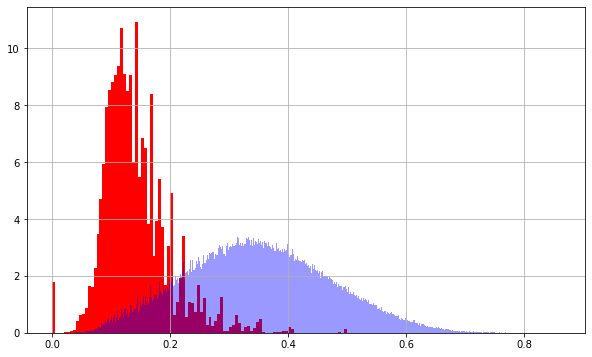

In [128]:
sim_same[np.logical_not(sel_same)].hist(bins = 100, density = True, color = "red")
sim_same.hist(bins = 500, density = True, color = "blue", alpha = .4)
plt.show()

In [129]:
import matplotlib.colors as cl

#I would like to have on the same graphics the two distributions, maybe I should threshold and only plot one color. We'll see later.

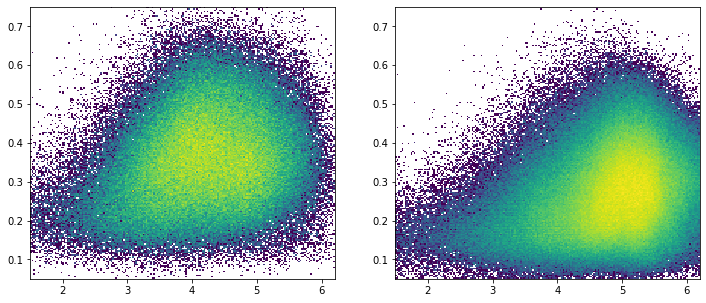

In [130]:
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
color_density_wfeatures(ll_same.loc[sel_same], sim_same[sel_same], ran = np.array([[1.5, 6.2], [.05, .75]]))

plt.subplot(1, 2, 2)
color_density_wfeatures(ll_diff.loc[sel_diff], sim_diff[sel_diff], ran = np.array([[1.5, 6.2], [.05, .75]]))

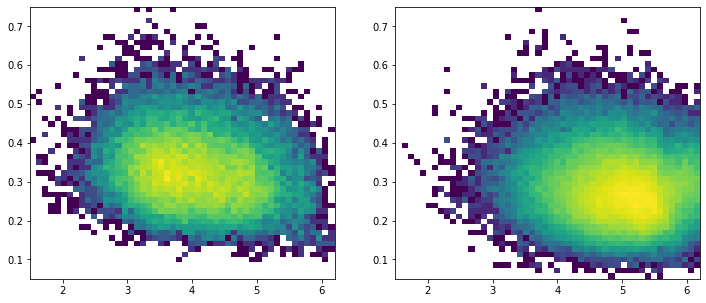

In [131]:
sel_same_5 = ll_same["nb_rows"] == 5
sel_diff_5 = ll_diff["nb_rows"] == 5

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
color_density_wfeatures(ll_same.loc[sel_same_5], sim_same[sel_same_5], ran = np.array([[1.5, 6.2], [.05, .75]],), bins = 50)

plt.subplot(1, 2, 2)
color_density_wfeatures(ll_diff.loc[sel_diff_5], sim_diff[sel_diff_5], ran = np.array([[1.5, 6.2], [.05, .75]]), bins = 50)

Conclusion :  adding the similarity index to obtain a 2-dimensional statistic allows for more precision, but it is stil not enough to clearly distinguish same molecules from distinct molecules.

In [39]:
ll_same

,Unnamed: 0,stat,nb_rows
0,0,0.000000,1.0
1,1,0.000000,1.0
2,2,0.000000,1.0
3,3,0.000000,1.0
4,4,0.000000,1.0
...,...,...,...
253739,253739,2485.545113,9.0
253740,253740,1923.433502,6.0
253741,253741,2309.263699,9.0
253742,253742,11617.846383,9.0


In [40]:
ll_same_i = ll_same.loc[sel_same_i]
sim_same_i = sim_same.loc[sel_same_i]

ll_diff_i = ll_diff.loc[sel_diff_i]
sim_diff_i = sim_diff.loc[sel_diff_i]

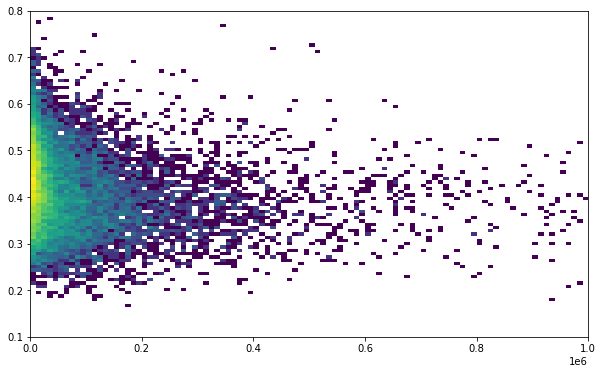

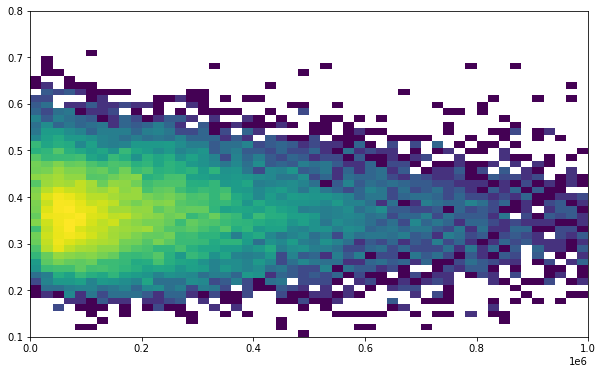

In [41]:
plt.hist2d(ll_same_i["stat"], sim_same_i, density = True, bins = 100, range = [[0, 1e6], [0.1, 0.8]], norm = cl.LogNorm())
plt.show()
plt.hist2d(ll_diff_i["stat"], sim_diff_i, density = True, bins = 50, range = [[0, 1e6], [0.1, 0.8]], norm = cl.LogNorm())
plt.show()

In [42]:
def find_b(points, a, alpha):
    """Points a couple of series, the first one containing similarity indices, the second one containing ll statistics."""
    sr = points[1] - a * points[0]
    return sr.quantile(alpha)

In [43]:
def power(points_H0, points_H1, a, alpha):
    b = find_b(points_H0, a, alpha)
    sr = points_H1[1] - a * points_H1[0] - b
    return sr[sr < 0].count() / len(points_H1[0])

In [44]:
pts_0 = [ll_same_i["stat"] / ll_same_i["stat"].mean(), sim_same_i / sim_same_i.mean()]

In [45]:
pts_1 = [ll_diff_i["stat"] / ll_same_i["stat"].mean(), sim_diff_i / sim_same_i.mean()]

In [88]:
def set_separation(pts_0, pts_1, a, alpha = 0.05, window = [[0.01, 10], [0.01, 2]], cmap = "viridis"):
    """Given a and alpha, infer a coefficient b for a line of equation y = a * x + b separating the dataset pts_0 at level
    alpha (i.e. a proportion alpha of the pts in pts_0 are under the line) and computes the power of the test, that is the
    frequency of pts in pts_1 that are under the line. Plots the graphics illustrating this process."""

    #For sparse datasets, it is useful to set the window manually to see something on the colorcharts.
    # The default window that is given is just convenient for the next graphics.
    [[xmin, xmax],
     [ymin, ymax]] = window
    
    b = find_b(pts_0, a, alpha) #Computes the coefficient

    x = np.linspace(max(xmin, (ymin - b) / a), min(xmax, (ymax - b) / a))
    y = a * x + b


    plt.figure(figsize = (14, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist2d(pts_0[0], pts_0[1], density = True, bins = 100, range = [[xmin, xmax], [ymin, ymax]], cmap = cmap, norm = cl.LogNorm())
    plt.colorbar()
    plt.plot(x, y, "k")
    
    print("level = ", alpha)
    print("b = ", b)

    plt.subplot(1, 2, 2)
    plt.hist2d(pts_1[0], pts_1[1], density = True, bins = 100, range = [[xmin, xmax], [ymin, ymax]], cmap = cmap, norm = cl.LogNorm())
    plt.colorbar()
    plt.plot(x, y, "k")
    plt.show()

    print("power = ", power(pts_0, pts_1, a, alpha))

In [89]:
sel_same_i = ll_same["nb_rows"] == 10
sel_diff_i = ll_diff["nb_rows"] == 10

ll_same_i = ll_same.loc[sel_same_i]
sim_same_i = sim_same.loc[sel_same_i]

ll_diff_i = ll_diff.loc[sel_diff_i]
sim_diff_i = sim_diff.loc[sel_diff_i]

#Normalize by the mean of the coordinates in the "same" datasets, which correspond to multiplicating the 2d points by a
#diagonal matrix. This is harmless for the algorithm separating points with a line because a linear application preserves lines.
pts_0 = [ll_same_i["stat"] / ll_same_i["stat"].mean(), sim_same_i / sim_same_i.mean()]
pts_1 = [ll_diff_i["stat"] / ll_same_i["stat"].mean(), sim_diff_i / sim_same_i.mean()]

level =  0.5
b =  0.622964148241321


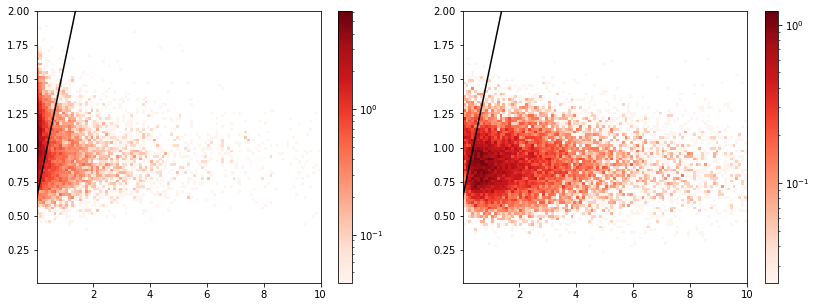

power =  0.9312255100662072


In [90]:
set_separation(pts_0, pts_1, 1, alpha = 0.5, cmap = "Reds")

In [49]:
def find_best_power(pts_0, pts_1, alpha, coeff_max = 20, step = 0.5):
    """Given alpha, approxiates the best power for a test of level alpha by the above method of
    separating data with a line. The data has to be normalized to be of the order of magnitude of 1."""
    m = 0
    for i in np.arange(start = 0, stop = coeff_max + step, step = step):
        phi = power(pts_0, pts_1, i, alpha)
        if phi > m:
            m = phi
            a = i
    return m, a, find_b(pts_0, a, alpha)

In [50]:
find_best_power(pts_0, pts_1, 0.1, coeff_max = 100, step = 0.1 )

(0.352610007656623, 0.30000000000000004, 0.1617394695473527)

level =  0.1
b =  0.16173946954735277


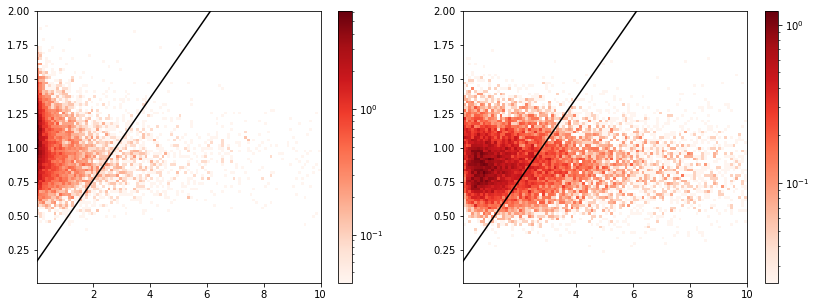

power =  0.352610007656623


In [91]:
set_separation(pts_0, pts_1, 0.3, alpha = 0.1, cmap = "Reds")

For 2 and 3, we get coefficients around 0.5 (so it relies a bit more on similarity index) and power of about 0.5 and 0.4 when setting alpha to 0.1

In [93]:
sel_same_i = ll_same["nb_rows"] == 10
sel_diff_i = ll_diff["nb_rows"] == 10

ll_same_i = np.log(ll_same.loc[sel_same_i]) / np.log(10)
sim_same_i = sim_same.loc[sel_same_i]

ll_diff_i = np.log(ll_diff.loc[sel_diff_i]) / np.log(10)
sim_diff_i = sim_diff.loc[sel_diff_i]

pts_0 = [ll_same_i["stat"] / ll_same_i["stat"].mean(), sim_same_i / sim_same_i.mean()]
pts_1 = [ll_diff_i["stat"] / ll_same_i["stat"].mean(), sim_diff_i / sim_same_i.mean()]

m, a, b = find_best_power(pts_0, pts_1, 0.1, coeff_max = 100, step = 0.2)

C:\Users\maloh\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


level =  0.1
b =  -4.10087456339363


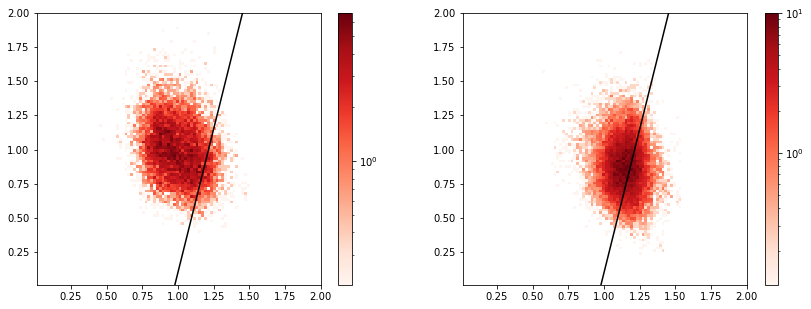

power =  0.3550871503850831


In [94]:
set_separation(pts_0, pts_1, a, alpha = 0.1,  window = [[0.01, 2], [0.01, 2]], cmap = "Reds")

In [95]:
a

4.2

In [96]:
sel_same_i = ll_same["nb_rows"] == 10
sel_diff_i = ll_diff["nb_rows"] == 10

ll_same_i = ll_same.loc[sel_same_i]
sim_same_i = sim_same.loc[sel_same_i]

ll_diff_i = ll_diff.loc[sel_diff_i]
sim_diff_i = sim_diff.loc[sel_diff_i]


pts_0 = [ll_same_i["stat"] / ll_same_i["stat"].mean(), sim_same_i / sim_same_i.mean()]
pts_1 = [ll_diff_i["stat"] / ll_same_i["stat"].mean(), sim_diff_i / sim_same_i.mean()]
    


In [97]:
levels = np.linspace(.05, 0.6, 20) #20 points should be enough, lower than 0.05 and higher than 0.6 is not relevant.
powers = []
slopes = []
constants = []
for alpha in levels:
    m, a, b = find_best_power(pts_0, pts_1, alpha = alpha, coeff_max = 2, step = 0.05)
    powers.append(m)
    slopes.append(a)
    constants.append(b)

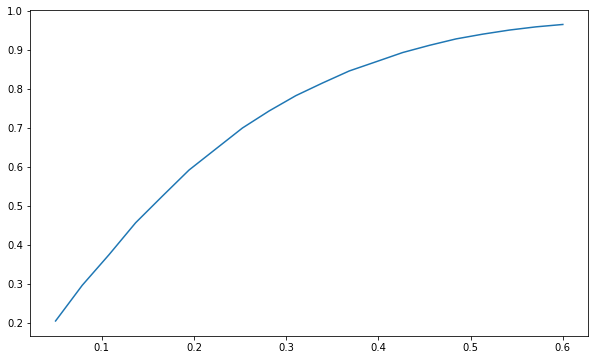

In [98]:
plt.plot(levels, powers)
plt.show()

In [99]:
sel_same_i = ll_same["nb_rows"] == 10
sel_diff_i = ll_diff["nb_rows"] == 10

ll_same_i = np.log(ll_same.loc[sel_same_i]) / np.log(10)
sim_same_i = sim_same.loc[sel_same_i]

ll_diff_i = np.log(ll_diff.loc[sel_diff_i]) / np.log(10)
sim_diff_i = sim_diff.loc[sel_diff_i]

pts_0 = [ll_same_i["stat"] / ll_same_i["stat"].mean(), sim_same_i / sim_same_i.mean()]
pts_1 = [ll_diff_i["stat"] / ll_same_i["stat"].mean(), sim_diff_i / sim_same_i.mean()]

C:\Users\maloh\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [100]:

powers_log = []
slopes_log = []
constants_log = []
for alpha in levels:
    m, a, b = find_best_power(pts_0, pts_1, alpha = alpha, coeff_max = 10, step = 0.25)
    powers_log.append(m)
    slopes_log.append(a)
    constants_log.append(b)

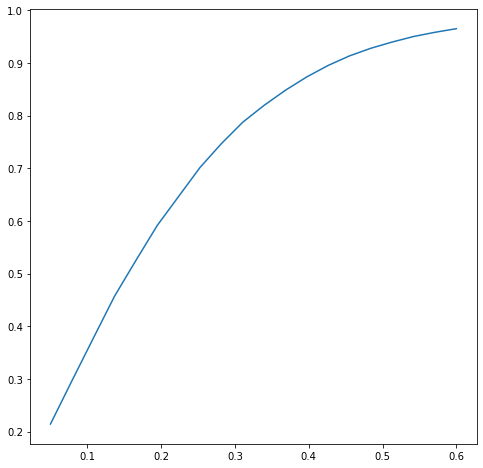

In [101]:
plt.figure(figsize = (8, 8))
plt.plot(levels, powers_log)
plt.show()

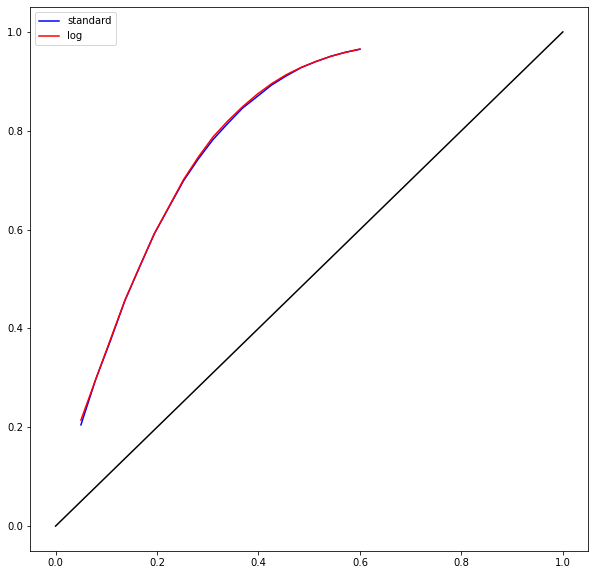

In [102]:
plt.figure(figsize = (10, 10))
plt.plot(levels, powers, "b", label = "standard")
plt.plot(levels, powers_log, "r", label = "log")
plt.plot(np.linspace(0, 1, 40), np.linspace(0, 1, 40), "k")
plt.legend()
plt.show()

In [103]:
levels = np.linspace(.01, 0.99, 40)
powers = []
slopes = []
constants = []
for alpha in levels:
    m, a, b = find_best_power(pts_0, pts_1, alpha = alpha, coeff_max = 2, step = 0.05)
    powers.append(m)
    slopes.append(a)
    constants.append(b)

In [104]:
powers_log = []
slopes_log = []
constants_log = []
for alpha in levels:
    m, a, b = find_best_power(pts_0, pts_1, alpha = alpha, coeff_max = 10, step = 0.25)
    powers_log.append(m)
    slopes_log.append(a)
    constants_log.append(b)

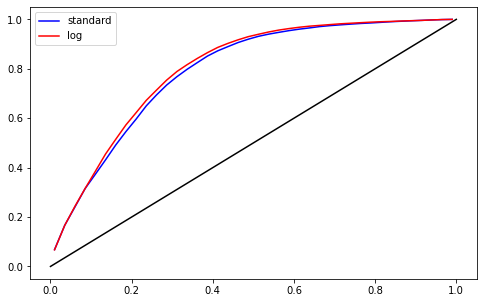

In [105]:
#Comparing roc curves to determine which one of standard or log scale is better

plt.figure(figsize = (8, 5))
plt.plot(levels, powers, "b", label = "standard")
plt.plot(levels, powers_log, "r", label = "log")
plt.plot(np.linspace(0, 1, 40), np.linspace(0, 1, 40), "k")
plt.legend()
plt.show()

In [115]:
m, a, b = find_best_power(pts_0, pts_1, alpha = 0.37, coeff_max = 5, step = 0.01)

level =  0.37
b =  -3.5320814766910336


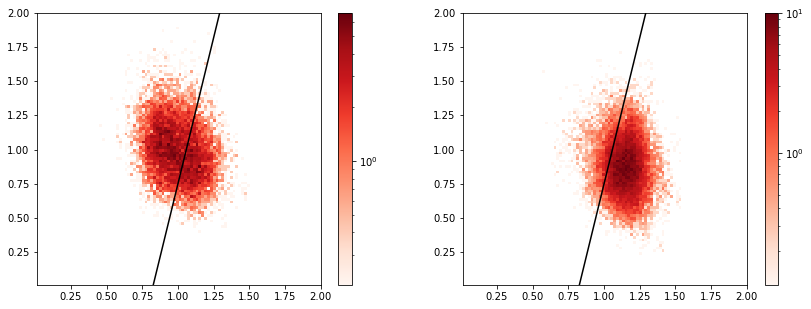

power =  0.8503355402423096


In [118]:
set_separation(pts_0, pts_1, a, alpha = 0.37,  window = [[0.01, 2], [0.01, 2]], cmap = "Reds")

In [119]:
lst = ll_same.groupby("nb_rows").count()

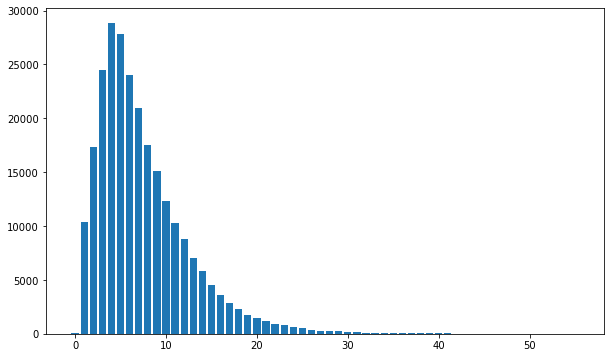

In [121]:
plt.bar(lst.index, lst["stat"])
plt.show()

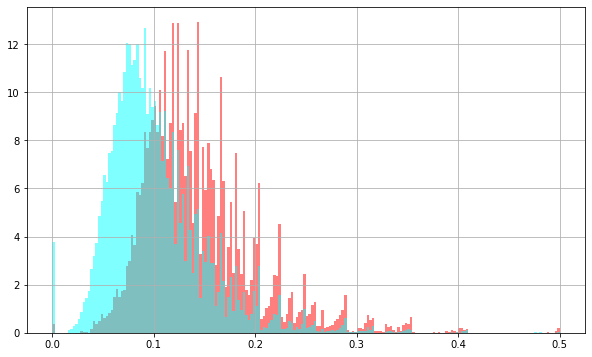

In [122]:
sim_same.loc[ll_same["nb_rows"] == 1].hist(bins = 200, density = True, color = "red", alpha = .5)
sim_diff.loc[ll_diff["nb_rows"] == 1].hist(bins = 200, density = True, color = "cyan", alpha = .5)
plt.show()

In [123]:
lst = ll_diff.groupby("nb_rows").count()

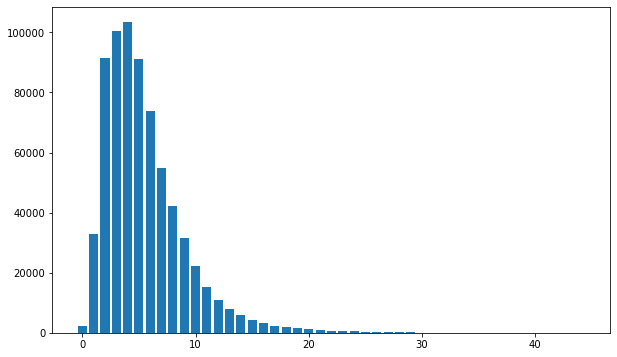

In [125]:
plt.bar(lst.index, lst["stat"])
plt.show()

In [ ]:
def color_scatter(ll, sim):
    a1 = np.log(ll.stat) / np.log(10)
    
    #plt.figure(figsize = (10, 10))
    plt.scatter(a1, sim, range = ran)

In [134]:
sel_same_i = ll_same["nb_rows"] == 10
sel_diff_i = ll_diff["nb_rows"] == 10

ll_same_i = np.log(ll_same.loc[sel_same_i]) / np.log(10)
sim_same_i = sim_same.loc[sel_same_i]

ll_diff_i = np.log(ll_diff.loc[sel_diff_i]) / np.log(10)
sim_diff_i = sim_diff.loc[sel_diff_i]

pts_0 = [ll_same_i["stat"] / ll_same_i["stat"].mean(), sim_same_i / sim_same_i.mean()]
pts_1 = [ll_diff_i["stat"] / ll_same_i["stat"].mean(), sim_diff_i / sim_same_i.mean()]

m, a, b = find_best_power(pts_0, pts_1, 0.1, coeff_max = 100, step = 0.2)

C:\Users\maloh\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [135]:
ll = pts_0[0]
sim = pts_0[1]

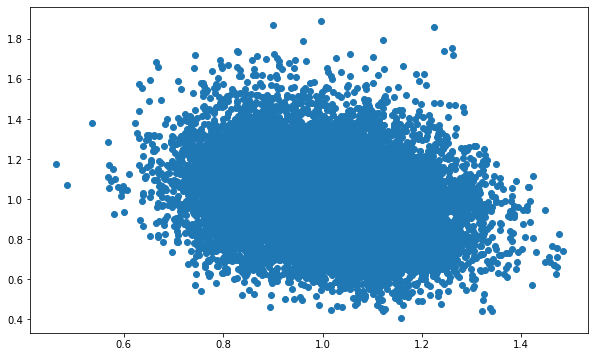

In [136]:
plt.scatter(ll, sim)

In [148]:

data["compounds"]["Fallopia"].index = data["compounds"]["Fallopia"]["compound_id"]
list_mq = []
for cid in cid_similar.cid:
    list_id = cid_spid[cid]
    for spid in combinations(list_id, 2):
        list_mq.append(data["compounds"]["Fallopia"]["compound_mq"][cid])
ll_same["mq"] = list_mq[:]

list_mq = []
for (cid1, cid2) in lst_couple_cid:
    mq = max(data["compounds"]["Fallopia"]["compound_mq"][cid1], data["compounds"]["Fallopia"]["compound_mq"][cid1])
    
    for spid1 in cid_spid[cid1]:
        for spid2 in cid_spid[cid2]:
            list_mq.append(mq)
ll_diff["mq_max"] = list_mq[:]



In [191]:
labeled_ll_same = ll_same.loc[ll_same["mq"] > 1e-3]
labeled_sim_same = sim_same[ll_same["mq"] > 1e-3]

labeled_ll_diff = ll_diff.loc[ll_diff["mq_max"] > 1e-3]
labeled_sim_diff = sim_diff.loc[ll_diff["mq_max"] > 1e-3]


sel_same_i = labeled_ll_same["nb_rows"] == 10
sel_diff_i = labeled_ll_diff["nb_rows"] == 10

ll_same_i = np.log(labeled_ll_same.loc[sel_same_i]) / np.log(10)
sim_same_i = labeled_sim_same.loc[sel_same_i]

ll_diff_i = np.log(labeled_ll_diff.loc[sel_diff_i]) / np.log(10)
sim_diff_i = labeled_sim_diff.loc[sel_diff_i]

pts_0 = [ll_same_i["stat"] / ll_same_i["stat"].mean(), sim_same_i / sim_same_i.mean()]
pts_1 = [ll_diff_i["stat"] / ll_same_i["stat"].mean(), sim_diff_i / sim_same_i.mean()]

m, a, b = find_best_power(pts_0, pts_1, 0.1, coeff_max = 100, step = 0.2)

level =  0.37
b =  -3.2160173179012195


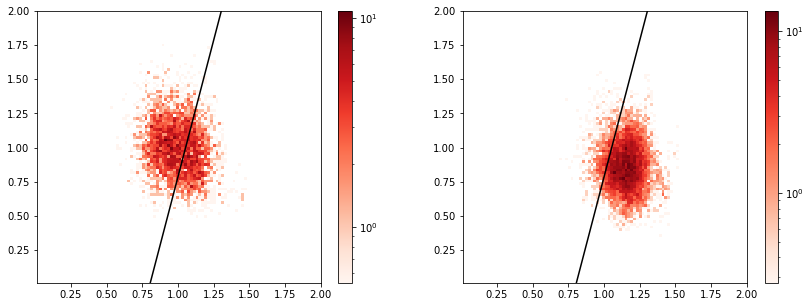

power =  0.8911130664320281


In [192]:
set_separation(pts_0, pts_1, a, alpha = 0.37,  window = [[0.01, 2], [0.01, 2]], cmap = "Reds")

In [193]:
labeled_ll_same = ll_same.loc[ll_same["mq"] > .85]
labeled_sim_same = sim_same[ll_same["mq"] > .85]

labeled_ll_diff = ll_diff.loc[ll_diff["mq_max"] > .85]
labeled_sim_diff = sim_diff.loc[ll_diff["mq_max"] > .85]


sel_same_i = labeled_ll_same["nb_rows"] == 10
sel_diff_i = labeled_ll_diff["nb_rows"] == 10

ll_same_i = np.log(labeled_ll_same.loc[sel_same_i]) / np.log(10)
sim_same_i = labeled_sim_same.loc[sel_same_i]

ll_diff_i = np.log(labeled_ll_diff.loc[sel_diff_i]) / np.log(10)
sim_diff_i = labeled_sim_diff.loc[sel_diff_i]

pts_0 = [ll_same_i["stat"] / ll_same_i["stat"].mean(), sim_same_i / sim_same_i.mean()]
pts_1 = [ll_diff_i["stat"] / ll_same_i["stat"].mean(), sim_diff_i / sim_same_i.mean()]

m, a, b = find_best_power(pts_0, pts_1, 0.1, coeff_max = 100, step = 0.2)

C:\Users\maloh\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


level =  0.1
b =  -13.904446466731676


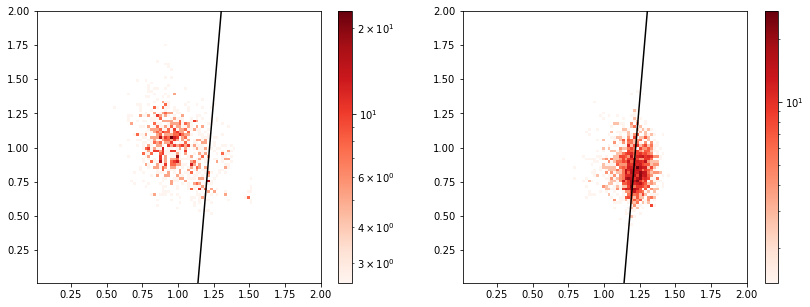

power =  0.5397849462365591


In [194]:
set_separation(pts_0, pts_1, a, alpha = 0.1,  window = [[0.01, 2], [0.01, 2]], cmap = "Reds")

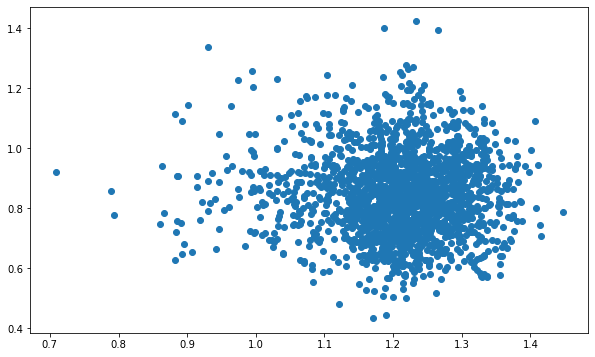

In [195]:
plt.scatter(pts_1[0], pts_1[1])

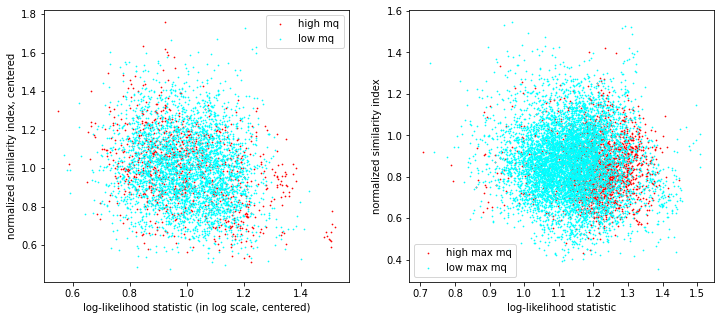

In [201]:
plt.figure(figsize = (12, 5))

size = .5

labeled_ll_same = ll_same.loc[ll_same["mq"] > 1e-3]
labeled_sim_same = sim_same[ll_same["mq"] > .1e-3]
labeled_ll_diff = ll_diff.loc[ll_diff["mq_max"] > 1e-3]
labeled_sim_diff = sim_diff.loc[ll_diff["mq_max"] > 1e-3]

#First plot the ones with high mq

goodlab_ll_same = labeled_ll_same[labeled_ll_same["mq"] > .85]
goodlab_sim_same = labeled_sim_same[labeled_ll_same["mq"] > .85]
goodlab_ll_diff = labeled_ll_diff[labeled_ll_diff["mq_max"] > .85]
goodlab_sim_diff = labeled_sim_diff[labeled_ll_diff["mq_max"] > .85]

sel_same_i = goodlab_ll_same["nb_rows"] == 10
sel_diff_i = goodlab_ll_diff["nb_rows"] == 10

ll_same_i = np.log(goodlab_ll_same.loc[sel_same_i]) / np.log(10)
sim_same_i = goodlab_sim_same.loc[sel_same_i]

ll_diff_i = np.log(goodlab_ll_diff.loc[sel_diff_i]) / np.log(10)
sim_diff_i = goodlab_sim_diff.loc[sel_diff_i]

pts_0 = [ll_same_i["stat"] / ll_same_i["stat"].mean(), sim_same_i / sim_same_i.mean()]
pts_1 = [ll_diff_i["stat"] / ll_same_i["stat"].mean(), sim_diff_i / sim_same_i.mean()]

plt.subplot(1, 2, 1)
plt.scatter(pts_0[0], pts_0[1], s = size, color = "red", label = "high mq")

plt.xlabel("log-likelihood statistic (in log scale, centered)")
plt.ylabel("normalized similarity index, centered")

plt.subplot(1, 2, 2)
plt.scatter(pts_1[0], pts_1[1], s= size, color = "red", label = "high max mq")

plt.xlabel("log-likelihood statistic")
plt.ylabel("normalized similarity index")


#Then the ones with low mq

mislab_ll_same = labeled_ll_same[labeled_ll_same["mq"] <= .85]
mislab_sim_same = labeled_sim_same[labeled_ll_same["mq"] <= .85]
mislab_ll_diff = labeled_ll_diff[labeled_ll_diff["mq_max"] <= .85]
mislab_sim_diff = labeled_sim_diff[labeled_ll_diff["mq_max"] <= .85]

sel_same_i = mislab_ll_same["nb_rows"] == 10
sel_diff_i = mislab_ll_diff["nb_rows"] == 10

ll_same_i = np.log(mislab_ll_same.loc[sel_same_i]) / np.log(10)
sim_same_i = mislab_sim_same.loc[sel_same_i]

ll_diff_i = np.log(mislab_ll_diff.loc[sel_diff_i]) / np.log(10)
sim_diff_i = mislab_sim_diff.loc[sel_diff_i]

pts_0 = [ll_same_i["stat"] / ll_same_i["stat"].mean(), sim_same_i / sim_same_i.mean()]
pts_1 = [ll_diff_i["stat"] / ll_same_i["stat"].mean(), sim_diff_i / sim_same_i.mean()]

plt.subplot(1, 2, 1)
plt.scatter(pts_0[0], pts_0[1], s = size, color = "cyan", label = "low mq")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(pts_1[0], pts_1[1], s = size, color = "cyan", label = "low max mq")
plt.legend()

plt.show()

In [181]:
a = np.log(labeled_ll_diff.loc[np.logical_not(sel_diff_i)]) / np.log(10)

C:\Users\maloh\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\maloh\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [188]:
ll_same_i["stat"].mean()

-inf

Text(0, 0.5, 'normalized similarity index, centered')

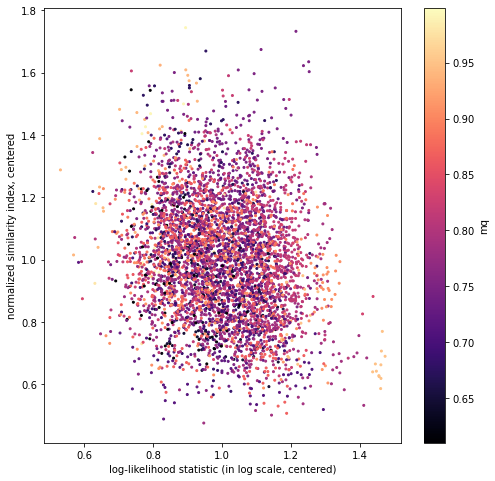

In [217]:
plt.figure(figsize = (8, 8))

size = 4

labeled_ll_same = ll_same.loc[ll_same["mq"] > 1e-3]
labeled_sim_same = sim_same[ll_same["mq"] > .1e-3]
labeled_ll_diff = ll_diff.loc[ll_diff["mq_max"] > 1e-3]
labeled_sim_diff = sim_diff.loc[ll_diff["mq_max"] > 1e-3]


sel_same_i = labeled_ll_same["nb_rows"] == 10
sel_diff_i = labeled_ll_diff["nb_rows"] == 10

ll_same_i = np.log(labeled_ll_same.loc[sel_same_i]) / np.log(10)
sim_same_i = labeled_sim_same.loc[sel_same_i]

ll_diff_i = np.log(labeled_ll_diff.loc[sel_diff_i]) / np.log(10)
sim_diff_i = labeled_sim_diff.loc[sel_diff_i]

pts_0 = [ll_same_i["stat"] / ll_same_i["stat"].mean(), sim_same_i / sim_same_i.mean()]
pts_1 = [ll_diff_i["stat"] / ll_same_i["stat"].mean(), sim_diff_i / sim_same_i.mean()]

plt.scatter(pts_0[0], pts_0[1], s = size, c = [mq for mq in labeled_ll_same.loc[sel_same_i]["mq"]], cmap = "magma", label = "high mq")
plt.colorbar(label = "mq")
plt.xlabel("log-likelihood statistic (in log scale, centered)")
plt.ylabel("normalized similarity index, centered")

It is not clear whether or not the compounds that have been identified better are more in the sense of the null hypothesis according to this statistic.

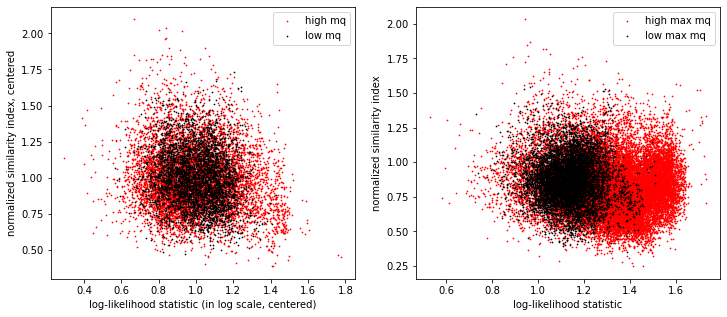

In [222]:
plt.figure(figsize = (12, 5))

size = .5

labeled_ll_same = ll_same.loc[ll_same["mq"] > 1e-3]
labeled_sim_same = sim_same[ll_same["mq"] > .1e-3]
labeled_ll_diff = ll_diff.loc[ll_diff["mq_max"] > 1e-3]
labeled_sim_diff = sim_diff.loc[ll_diff["mq_max"] > 1e-3]

#First plot the ones with high mq

goodlab_ll_same = labeled_ll_same[labeled_ll_same["mq"] > .85]
goodlab_sim_same = labeled_sim_same[labeled_ll_same["mq"] > .85]
goodlab_ll_diff = labeled_ll_diff[labeled_ll_diff["mq_max"] > .85]
goodlab_sim_diff = labeled_sim_diff[labeled_ll_diff["mq_max"] > .85]

sel_same_i = goodlab_ll_same["nb_rows"] == 5
sel_diff_i = goodlab_ll_diff["nb_rows"] == 5

ll_same_i = np.log(goodlab_ll_same.loc[sel_same_i]) / np.log(10)
sim_same_i = goodlab_sim_same.loc[sel_same_i]

ll_diff_i = np.log(goodlab_ll_diff.loc[sel_diff_i]) / np.log(10)
sim_diff_i = goodlab_sim_diff.loc[sel_diff_i]

pts_0 = [ll_same_i["stat"] / ll_same_i["stat"].mean(), sim_same_i / sim_same_i.mean()]
pts_1 = [ll_diff_i["stat"] / ll_same_i["stat"].mean(), sim_diff_i / sim_same_i.mean()]

plt.subplot(1, 2, 1)
plt.scatter(pts_0[0], pts_0[1], s = size, color = "red", label = "high mq")

plt.xlabel("log-likelihood statistic (in log scale, centered)")
plt.ylabel("normalized similarity index, centered")

plt.subplot(1, 2, 2)
plt.scatter(pts_1[0], pts_1[1], s= size, color = "red", label = "high max mq")

plt.xlabel("log-likelihood statistic")
plt.ylabel("normalized similarity index")


#Then the ones with low mq

mislab_ll_same = labeled_ll_same[labeled_ll_same["mq"] <= .85]
mislab_sim_same = labeled_sim_same[labeled_ll_same["mq"] <= .85]
mislab_ll_diff = labeled_ll_diff[labeled_ll_diff["mq_max"] <= .85]
mislab_sim_diff = labeled_sim_diff[labeled_ll_diff["mq_max"] <= .85]

sel_same_i = mislab_ll_same["nb_rows"] == 10
sel_diff_i = mislab_ll_diff["nb_rows"] == 10

ll_same_i = np.log(mislab_ll_same.loc[sel_same_i]) / np.log(10)
sim_same_i = mislab_sim_same.loc[sel_same_i]

ll_diff_i = np.log(mislab_ll_diff.loc[sel_diff_i]) / np.log(10)
sim_diff_i = mislab_sim_diff.loc[sel_diff_i]

pts_0 = [ll_same_i["stat"] / ll_same_i["stat"].mean(), sim_same_i / sim_same_i.mean()]
pts_1 = [ll_diff_i["stat"] / ll_same_i["stat"].mean(), sim_diff_i / sim_same_i.mean()]

plt.subplot(1, 2, 1)
plt.scatter(pts_0[0], pts_0[1], s = size, color = "k", label = "low mq")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(pts_1[0], pts_1[1], s = size, color = "k", label = "low max mq")
plt.legend()

plt.show()